# Do DL models and training environments have an impact on the energy consumption of computer vision training?

Author: Santiago del Rey

## Import libraries

In [1]:
import os
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import scikit_posthocs as sp
import seaborn as sns
from cliffs_delta import cliffs_delta
from scipy import stats

from src.data.analysis import test_assumptions, boxplot, barplot, eta_squared, is_pareto_efficient, print_improvement
from src.environment import FIGURES_DIR, METRICS_DIR
from src.data.preprocessing import GJOULES_TO_KJOULES, HOURS_TO_MILISECONDS

SAVE_FIGS = True

sns.set_theme(palette="colorblind", color_codes=True)

%matplotlib inline

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "Times New Roman"
mpl.rcParams["font.weight"] = "bold"
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.autolayout"] = "true"

## Load the dataset

In [2]:
analysis_df = pd.read_parquet(os.path.join(METRICS_DIR, "processed", "dl-training-energy-consumption-dataset.gzip"))
analysis_df.head()

,training environment,architecture,run,training duration (h),gpu model,gpu working time (h),gpu usage (%),gpu memory working time (h),gpu memory usage,average memory used (MB),...,validation size,batch size,GFLOPs,accuracy,precision,recall,AUC,trained epochs,total seen images,f1-score
0,Cloud,mobilenet_v2,0,0.734750,NVIDIA GeForce RTX 3090,0.168889,23.004162,0.061686,0.084022,23648.749527,...,10203,32,0.064028,0.975629,0.959826,0.993169,0.995675,88,2987776,0.976213
1,Cloud,mobilenet_v2,1,0.795914,NVIDIA GeForce RTX 3090,0.182600,22.960531,0.066108,0.083126,23657.000000,...,10203,32,0.064028,0.971108,0.957560,0.986339,0.992465,92,3123584,0.971736
2,Cloud,mobilenet_v2,2,0.471948,NVIDIA GeForce RTX 3090,0.105261,22.316843,0.038169,0.080925,23657.000000,...,10203,32,0.064028,0.960397,0.956488,0.965262,0.987073,55,1867360,0.960855
3,Cloud,mobilenet_v2,3,0.634343,NVIDIA GeForce RTX 3090,0.144261,22.758107,0.052850,0.083374,23657.000000,...,10203,32,0.064028,0.974941,0.962921,0.988290,0.994777,74,2512448,0.975441
4,Cloud,mobilenet_v2,4,0.662703,NVIDIA GeForce RTX 3090,0.150069,22.661493,0.053986,0.081523,23657.000000,...,10203,32,0.064028,0.968553,0.957524,0.981070,0.990629,76,2580352,0.969154


## Data analysis

In [3]:
TRAIN_STRATEGIES = ["Local N", "Local ML", "Cloud"]
MARKERS = {"Mobilenet V2": "o", "NASNet Mobile": "v", "Xception": "^", "ResNet50": "X", "VGG16": "P"}
COLORS = {"Local N": "b", "Local ML": "orange", "Cloud": "g"}
ARCHITECTURE_LABELS = ["Mobilenet\nV2", "NASNet\nMobile", "ResNet50", "VGG16", "Xception"]

analysis_df.rename(
    columns={
        "energy (GJ)": "energy",
        "gpu usage (%)": "gpu_usage",
        "average temperature (Celsius)": "temperature",
        "emissions (tCO2e)": "emissions",
    },
    inplace=True,
)

analysis_df.replace(
    {
        "Local Normal User": "Local N",
        "Local ML Engineer/Gamer": "Local ML",
        "mobilenet_v2": "Mobilenet V2",
        "nasnet_mobile": "NASNet Mobile",
        "xception": "Xception",
        "resnet50": "ResNet50",
        "vgg16": "VGG16",
    },
    inplace=True,
)

analysis_df["raw energy"] = analysis_df.energy.copy()
analysis_df["energy"] = analysis_df["raw energy"] * GJOULES_TO_KJOULES / analysis_df["total seen images"]
analysis_df["normalized duration"] = (
    analysis_df["training duration (h)"] * HOURS_TO_MILISECONDS / analysis_df["total seen images"]
)

In [4]:
local_n_mobilenet = analysis_df.query("`training environment` == 'Local N' & architecture == 'Mobilenet V2'")
local_n_nasnet = analysis_df.query("`training environment` == 'Local N' & architecture == 'NASNet Mobile'")

local_ml_mobilenet = analysis_df.query("`training environment` == 'Local ML' & architecture == 'Mobilenet V2'")
local_ml_nasnet = analysis_df.query("`training environment` == 'Local ML' & architecture == 'NASNet Mobile'")
local_ml_xception = analysis_df.query("`training environment` == 'Local ML' & architecture == 'Xception'")
local_ml_resnet50 = analysis_df.query("`training environment` == 'Local ML' & architecture == 'ResNet50'")
local_ml_vgg16 = analysis_df.query("`training environment` == 'Local ML' & architecture == 'VGG16'")


cloud_mobilenet = analysis_df.query("`training environment` == 'Cloud' & architecture == 'Mobilenet V2'")
cloud_nasnet = analysis_df.query("`training environment` == 'Cloud' & architecture == 'NASNet Mobile'")
cloud_xception = analysis_df.query("`training environment` == 'Cloud' & architecture == 'Xception'")
cloud_resnet50 = analysis_df.query("`training environment` == 'Cloud' & architecture == 'ResNet50'")
cloud_vgg16 = analysis_df.query("`training environment` == 'Cloud' & architecture == 'VGG16'")

### Look for outliers

#### Energy
##### Cloud
Looking at the boxplots we observe some extreme outliers. In this case in the NASNet, Xception and VGG16 architectures.

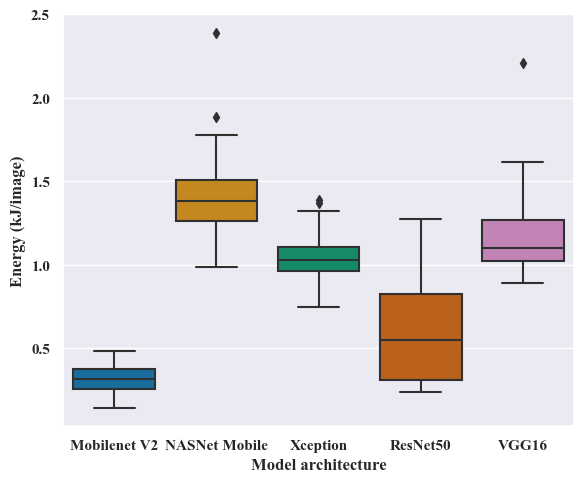

In [5]:
boxplot(
    pd.concat([cloud_mobilenet, cloud_nasnet, cloud_xception, cloud_resnet50, cloud_vgg16]),
    x="architecture",
    y="energy",
    xlabel="Model architecture",
    ylabel="Energy (kJ/image)",
    figname="cloud-energy-boxplot.pdf",
    figsize=(6, 5),
)

We manually inspect the outliers to see if they should be removed or not.

In [6]:
sorted_cloud_nasnet = cloud_nasnet.sort_values(by="energy", ascending=False)
pd.concat([sorted_cloud_nasnet.iloc[:5], sorted_cloud_nasnet.iloc[-5:]])[
    [
        "run",
        "training duration (h)",
        "trained epochs",
        "gpu_usage",
        "temperature",
        "raw energy",
        "energy",
        "normalized duration",
    ]
]

,run,training duration (h),trained epochs,gpu_usage,temperature,raw energy,energy,normalized duration
31,1,1.688808,85,34.553248,56.873228,6.893005,2.388495,2.106680
30,0,1.374044,72,35.466208,57.039255,4.609343,1.885564,2.023510
33,3,1.300914,68,35.315879,56.850823,4.094764,1.773596,2.028508
46,16,1.385753,86,42.106605,54.306766,4.861139,1.664847,1.708537
32,2,1.157140,58,33.389476,56.491831,3.177674,1.613675,2.115412
53,23,0.999810,63,41.592098,54.235114,2.531870,1.183683,1.682729
43,13,0.995117,63,41.935141,54.285155,2.511076,1.173962,1.674829
37,7,0.975052,62,41.643367,54.558345,2.423675,1.151376,1.667528
38,8,0.940801,60,41.771141,54.534595,2.256944,1.107909,1.662584
45,15,0.849968,54,41.209493,54.024550,1.811757,0.988191,1.668960


In [7]:
cloud_nasnet_no_energy_outliers = sorted_cloud_nasnet.iloc[1:]
print("Cloud NASNet Mobile remaining samples:", cloud_nasnet_no_energy_outliers.shape[0])

Cloud NASNet Mobile remaining samples: 29


In [8]:
sorted_cloud_xception = cloud_xception.sort_values(by="energy", ascending=False)
pd.concat([sorted_cloud_xception.iloc[:10], sorted_cloud_xception.iloc[-10:]])[
    [
        "run",
        "training duration (h)",
        "trained epochs",
        "gpu_usage",
        "temperature",
        "raw energy",
        "energy",
        "normalized duration",
    ]
]

,run,training duration (h),trained epochs,gpu_usage,temperature,raw energy,energy,normalized duration
131,11,1.150497,98,60.352102,62.981634,4.618551,1.388080,1.244792
138,18,1.132989,96,60.091288,62.834601,4.467028,1.370509,1.251387
120,0,1.092949,93,60.305775,62.979649,4.164040,1.318762,1.246103
129,9,1.052702,88,59.246430,62.670809,3.808129,1.274570,1.268410
132,12,0.968240,81,58.961771,62.564530,3.207334,1.166256,1.267463
139,19,0.954149,81,59.355478,62.699883,3.152699,1.146389,1.249017
133,13,0.939701,80,59.578107,62.661834,3.060128,1.126638,1.245480
140,20,0.922731,79,60.222959,62.820428,2.964804,1.105359,1.238469
146,26,0.915743,78,60.079635,62.820365,2.907965,1.098068,1.244848
127,7,0.914669,78,59.518564,62.764151,2.897689,1.094188,1.243388


In [9]:
sorted_cloud_vgg16 = cloud_vgg16.sort_values(by="energy", ascending=False)
pd.concat([sorted_cloud_vgg16.iloc[:5], sorted_cloud_vgg16.iloc[-5:]])[
    [
        "run",
        "training duration (h)",
        "trained epochs",
        "gpu_usage",
        "temperature",
        "raw energy",
        "energy",
        "normalized duration",
    ]
]

,run,training duration (h),trained epochs,gpu_usage,temperature,raw energy,energy,normalized duration
116,26,1.179458,81,94.128568,64.980656,6.068957,2.206804,1.543955
110,20,1.127005,101,90.826709,64.893360,5.537989,1.614973,1.183155
90,0,1.019880,88,90.417349,64.718494,4.497965,1.505456,1.228863
111,21,1.036114,93,90.732009,64.769871,4.654908,1.474222,1.181304
114,24,0.912780,74,91.826882,64.651935,3.614925,1.438806,1.307891
119,29,0.722134,67,90.413713,64.747689,2.259494,0.993278,1.142826
108,18,0.722120,67,89.649461,64.699923,2.259083,0.993098,1.142804
100,10,0.722126,67,89.660632,64.694145,2.256139,0.991804,1.142814
91,1,0.700975,66,89.948016,64.735714,2.131535,0.951225,1.126148
103,13,0.658459,62,89.983101,64.622729,1.877494,0.891911,1.126093


In [10]:
cloud_vgg16_no_energy_outliers = sorted_cloud_vgg16.iloc[1:]
print("Cloud VGG16 remaining samples:", cloud_vgg16_no_energy_outliers.shape[0])

Cloud VGG16 remaining samples: 29


After inspecting the data, we decide to remove the extreme outliers of the NASNet Mobile and VGG16 architectures.

##### Local ML
Again, we observe some outliers. In this case in the Xception architecture.

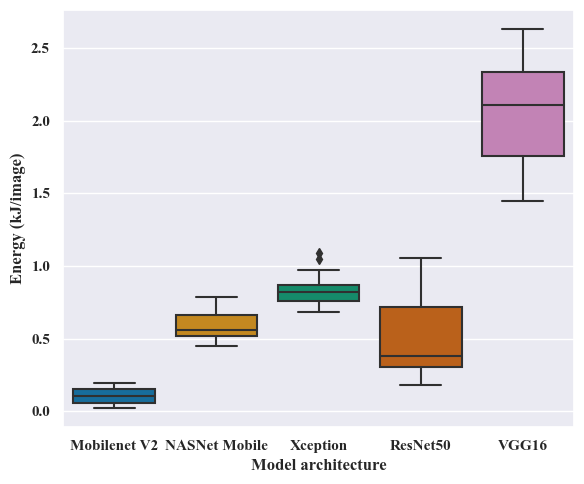

In [11]:
boxplot(
    pd.concat(
        [
            local_ml_mobilenet,
            local_ml_nasnet,
            local_ml_xception,
            local_ml_resnet50,
            local_ml_vgg16,
        ]
    ),
    x="architecture",
    y="energy",
    xlabel="Model architecture",
    ylabel="Energy (kJ/image)",
    figname="local-v2-energy-boxplot.pdf",
    figsize=(6, 5),
)

We proceed to review the outliers to decide whether to remove them or not. Looking at the data, it seems the outliers are a natural outcome of the training process rather than a measurement error or sampling problems.

In [12]:
local_ml_xception.sort_values(by="energy", ascending=False)[
    [
        "run",
        "training duration (h)",
        "trained epochs",
        "gpu_usage",
        "temperature",
        "raw energy",
        "energy",
        "normalized duration",
    ]
]

,run,training duration (h),trained epochs,gpu_usage,temperature,raw energy,energy,normalized duration
368,29,1.139417,87,92.827191,64.843300,3.216958,1.089083,1.388675
367,28,1.099361,84,93.179863,64.800911,2.989360,1.048174,1.387708
363,24,1.023988,79,93.256654,64.736828,2.599637,0.969215,1.374374
348,9,1.022872,80,92.931485,64.745242,2.576403,0.948546,1.355715
361,22,0.956943,74,92.972973,64.576286,2.266038,0.901924,1.371170
345,6,0.967518,76,92.999713,64.656223,2.308769,0.894750,1.349840
352,13,0.944421,73,93.225559,64.701413,2.191870,0.884355,1.371765
350,11,0.919678,70,93.107650,64.706078,2.060517,0.866988,1.393076
366,27,0.918272,71,92.964264,64.763174,2.087063,0.865789,1.371355
347,8,0.926627,73,93.026711,64.617947,2.105123,0.849355,1.345920


##### Local vs. Cloud
For the Local vs. Cloud analysis of energy, we do not observe any outliers.

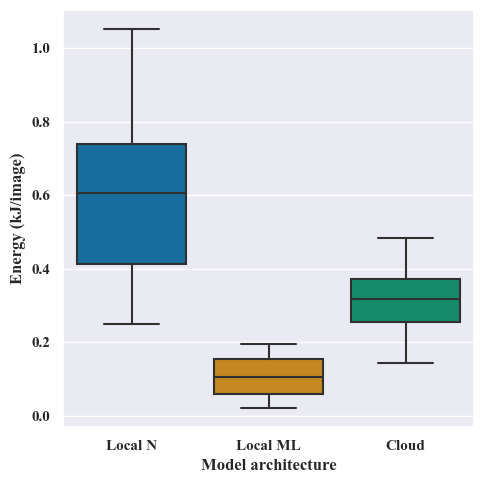

In [13]:
boxplot(
    pd.concat([local_n_mobilenet, local_ml_mobilenet, cloud_mobilenet]),
    x="training environment",
    y="energy",
    xlabel="Model architecture",
    ylabel="Energy (kJ/image)",
    figname="local-vs-cloud-energy-boxplot.pdf",
)

#### GPU usage
##### Cloud

For the GPU usage we observe the presence of outliers in the MobileNet V2, NASNet Mobile, ResNet50 and VGG16 measurements. However, we only remove the outliers of the NASNet and ResNet50 architectures, which are the most extreme.

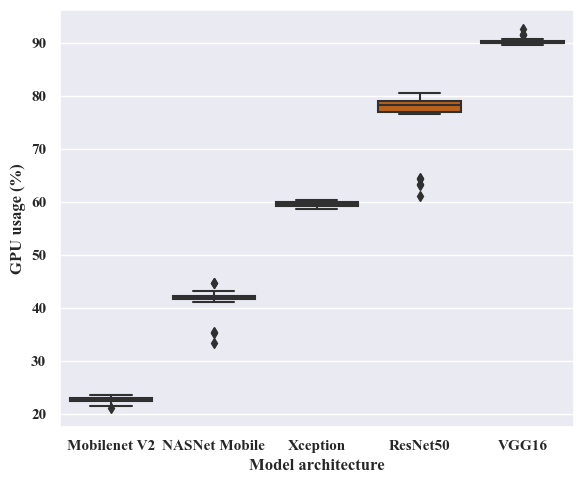

In [14]:
cloud_gpu_data = pd.concat(
    [
        cloud_mobilenet,
        cloud_nasnet_no_energy_outliers,
        cloud_xception,
        cloud_resnet50,
        cloud_vgg16_no_energy_outliers,
    ]
)
boxplot(
    cloud_gpu_data,
    x="architecture",
    y="gpu_usage",
    xlabel="Model architecture",
    ylabel="GPU usage (%)",
    figname="cloud-gpu_usage-boxplot.pdf",
    figsize=(6, 5),
)

In [15]:
cloud_nasnet_no_gpu_outliers = cloud_nasnet_no_energy_outliers.sort_values(by="gpu_usage", ascending=True).iloc[3:]
print("Cloud NASNet remaining samples:", cloud_nasnet_no_gpu_outliers.shape[0])
cloud_resnet50_no_gpu_outliers = cloud_resnet50.sort_values(by="gpu_usage", ascending=True).iloc[5:]
print("Cloud ResNet50 remaining samples:", cloud_resnet50_no_gpu_outliers.shape[0])

Cloud NASNet remaining samples: 26
Cloud ResNet50 remaining samples: 25


##### Local ML

In the Local ML environment, we observe that only MobileNet V2 has extreme outliers. We decide to remove them.

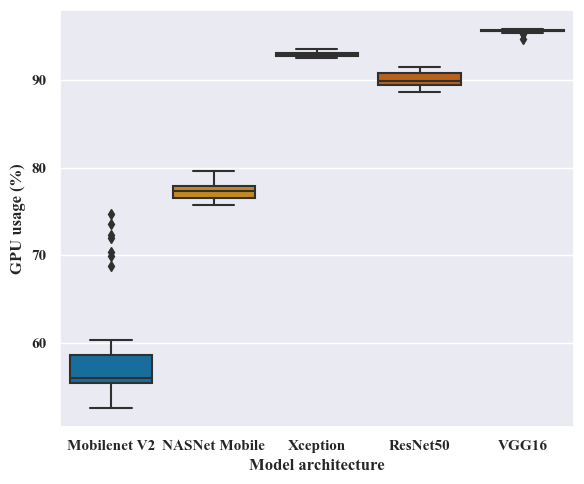

In [16]:
boxplot(
    pd.concat(
        [
            local_ml_mobilenet,
            local_ml_nasnet,
            local_ml_xception,
            local_ml_resnet50,
            local_ml_vgg16,
        ]
    ),
    x="architecture",
    y="gpu_usage",
    xlabel="Model architecture",
    ylabel="GPU usage (%)",
    figname="local-v2-gpu_usage-boxplot.pdf",
    figsize=(6, 5),
)

In [17]:
local_ml_mobilenet_no_gpu_outliers = local_ml_mobilenet.sort_values(by="gpu_usage", ascending=True).iloc[:-7]
print("Local ML MobileNet remaining samples:", local_ml_mobilenet_no_gpu_outliers.shape[0])

Local ML MobileNet remaining samples: 30


##### Local vs. Cloud

For the Local vs. Cloud analysis of GPU usage, we do not observe any extreme outliers that should be removed.

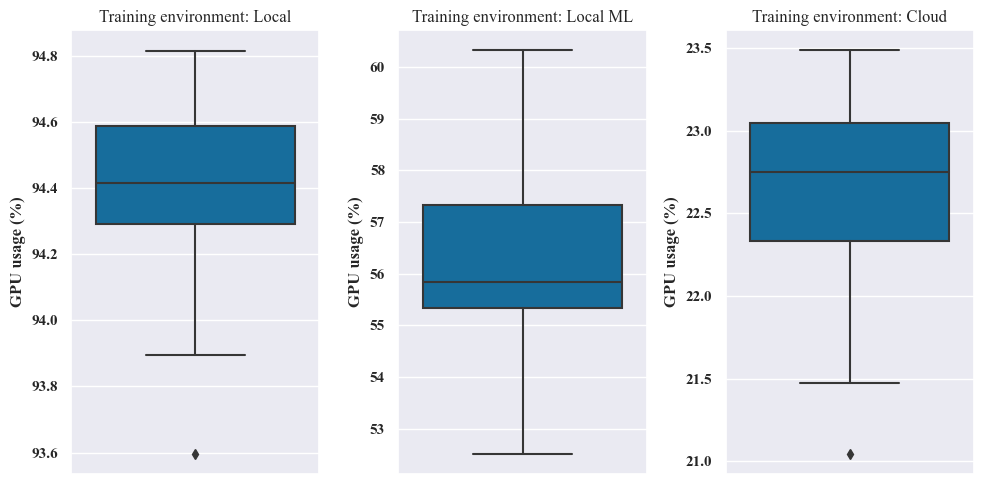

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
sns.boxplot(y=local_n_mobilenet.gpu_usage, ax=ax1)
ax1.set_ylabel("GPU usage (%)")
ax1.set_title("Training environment: Local")

sns.boxplot(y=local_ml_mobilenet_no_gpu_outliers.gpu_usage, ax=ax2)
ax2.set_ylabel("GPU usage (%)")
ax2.set_title("Training environment: Local ML")

sns.boxplot(y=cloud_mobilenet.gpu_usage, ax=ax3)
ax3.set_ylabel("GPU usage (%)")
ax3.set_title("Training environment: Cloud")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "cloud-local-gpu_usage-boxplot.pdf"))

#### Temperature
##### Cloud
Now we look for outliers in the temperature of the Cloud architecture. If we look at the boxplots, we observe that the Xception and VGG16 architectures have some outliers. However, these outliers are not extreme and we decide to keep them.

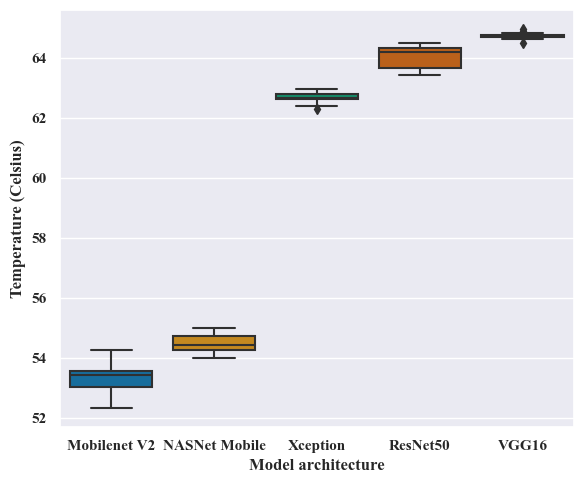

In [19]:
boxplot(
    pd.concat(
        [
            cloud_mobilenet,
            cloud_nasnet_no_gpu_outliers,
            cloud_xception,
            cloud_resnet50_no_gpu_outliers,
            cloud_vgg16_no_energy_outliers,
        ]
    ),
    x="architecture",
    y="temperature",
    xlabel="Model architecture",
    ylabel="Temperature (Celsius)",
    figname="cloud-temp-boxplot.pdf",
    figsize=(6, 5),
)

##### Local N
We check the outliers for the Local "Normal User" environment. In this case, we do not observe any outliers in the data.

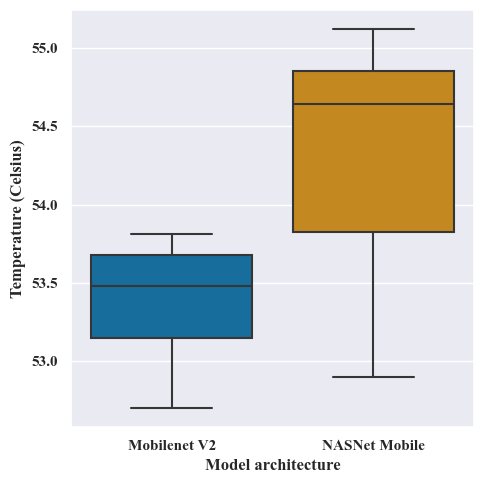

In [20]:
boxplot(
    pd.concat([local_n_mobilenet, local_n_nasnet]),
    x="architecture",
    y="temperature",
    xlabel="Model architecture",
    ylabel="Temperature (Celsius)",
    figname="local-temp-boxplot.pdf",
)

##### Local ML
In the Local ML environment, we observe that MobileNet V2, Xception, and ResNet50 have outliers. However, we decide to keep them given the small difference in temperature of the outliers with the remaining samples of each group.

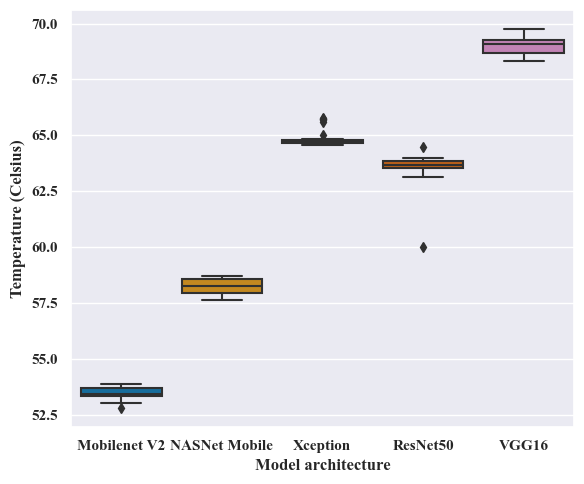

In [21]:
boxplot(
    pd.concat(
        [local_ml_mobilenet_no_gpu_outliers, local_ml_nasnet, local_ml_xception, local_ml_resnet50, local_ml_vgg16]
    ),
    x="architecture",
    y="temperature",
    xlabel="Model architecture",
    ylabel="Temperature (Celsius)",
    figname="local-v2-temp-boxplot.pdf",
    figsize=(6, 5),
)

#### F1-score
Given that the variation in F1-score is a natural outcome of the training process, we only remove those samples that have a F1-score of 0. This is because a F1-score of 0 indicates that the model is not able to predict any of the classes, which is a extraneous behavior.

In [22]:
mobilenet = pd.concat([local_n_mobilenet, local_ml_mobilenet_no_gpu_outliers, cloud_mobilenet])
nasnet = pd.concat([local_n_nasnet, local_ml_nasnet, cloud_nasnet_no_gpu_outliers])
xception = pd.concat([local_ml_xception, cloud_xception])
resnet50 = pd.concat([local_ml_resnet50, cloud_resnet50_no_gpu_outliers])
vgg16 = pd.concat([local_ml_vgg16, cloud_vgg16_no_energy_outliers])
f1_df = pd.concat([mobilenet, nasnet, xception, resnet50, vgg16]).query("`f1-score` > 0")

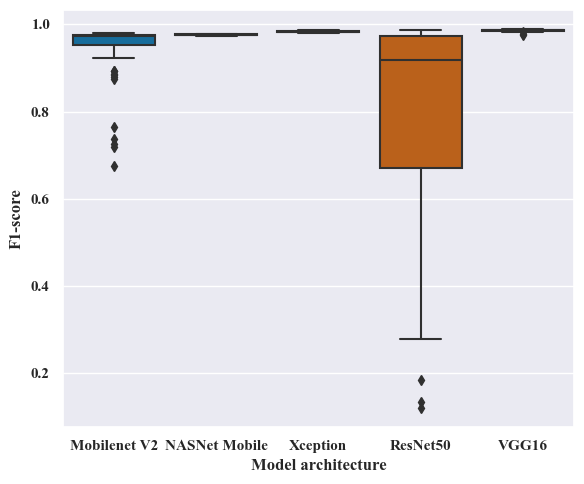

In [23]:
boxplot(
    f1_df,
    x="architecture",
    y="f1-score",
    xlabel="Model architecture",
    ylabel="F1-score",
    figname="f1score-boxplot.pdf",
    figsize=(6, 5),
)

### Impact of temperature on energy consumption

In [24]:
temp_vs_energy_df = pd.concat(
    [
        cloud_mobilenet,
        cloud_nasnet_no_energy_outliers,
        cloud_xception,
        cloud_resnet50_no_gpu_outliers,
        cloud_vgg16_no_energy_outliers,
        local_n_mobilenet,
        local_n_nasnet,
        local_ml_mobilenet_no_gpu_outliers,
        local_ml_nasnet,
        local_ml_xception,
        local_ml_resnet50,
        local_ml_vgg16,
    ]
)

Looking at the scatter plot of the temperature vs. energy, we do not observe any clear correlation between the two variables in a general view. However, this might not be the case when we look at the data for each environment separately.

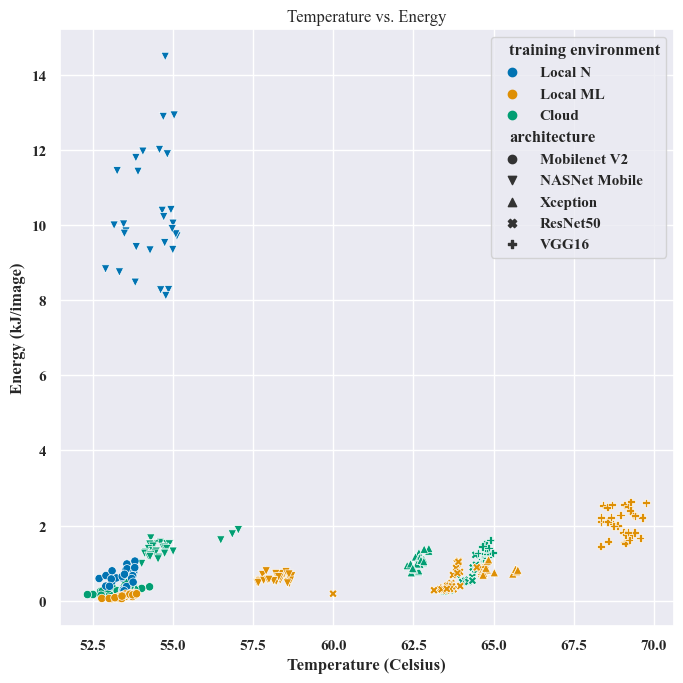

In [25]:
_, axes = plt.subplots(1, 1, figsize=((7, 7)))
ax = sns.scatterplot(
    temp_vs_energy_df,
    x="temperature",
    y="energy",
    ax=axes,
    style="architecture",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    markers=MARKERS,
)
ax.set_title("Temperature vs. Energy")
ax.set_xlabel("Temperature (Celsius)")
ax.set_ylabel("Energy (kJ/image)")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "temperature-energy-scatter.pdf"))

plt.show()

#### Test normality assumption
Before performing any statistical analysis, we need to check if the data is normally distributed. We do this by observing the Q-Q plot of the data and by performing the Shapiro-Wilk test.

Shapiro test for normality of group 0: W = 0.7680411338806152 and p-value 9.210459407963875e-14
Shapiro test for normality of group 1: W = 0.9412909150123596 and p-value 1.055921438819496e-05
Levene test for equal variances: W = 149.67926654390396 and p-value = 6.256355429353634e-28


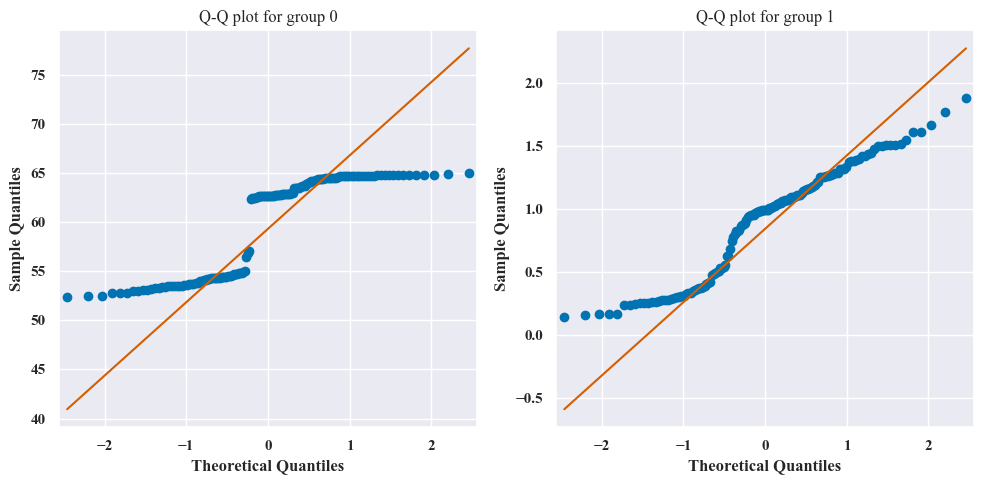

In [26]:
cloud_df = temp_vs_energy_df.query("`training environment` == 'Cloud'")
test_assumptions(cloud_df["temperature"], cloud_df["energy"], nrows=1, ncols=2, figsize=(10, 5))

Shapiro test for normality of group 0: W = 0.9090379476547241 and p-value 0.00028551919967867434
Shapiro test for normality of group 1: W = 0.7778443098068237 and p-value 3.943324955457683e-08
Levene test for equal variances: W = 513.9717609037189 and p-value = 8.109738896458531e-45


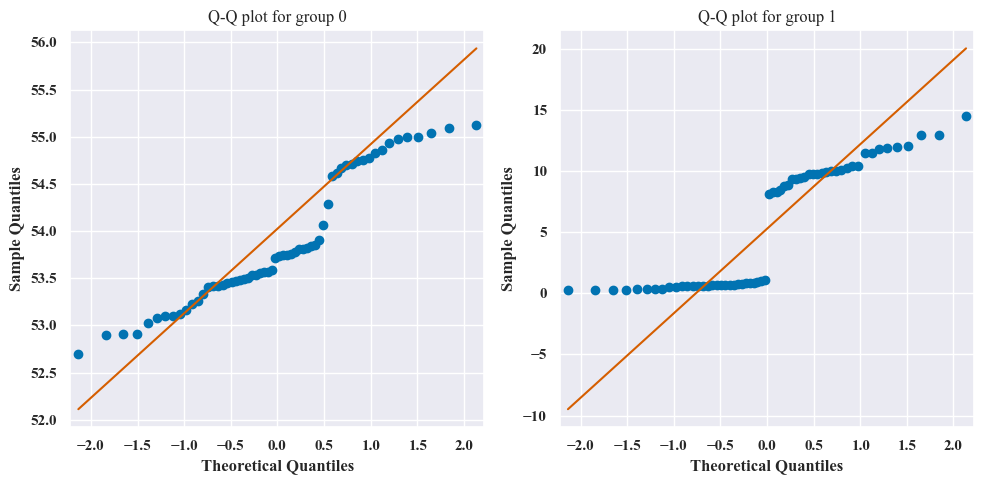

In [27]:
local_n_df = temp_vs_energy_df.query("`training environment` == 'Local N'")
test_assumptions(local_n_df["temperature"], local_n_df["energy"], nrows=1, ncols=2, figsize=(10, 5))

Shapiro test for normality of group 0: W = 0.8964983820915222 and p-value 7.090301679113509e-09
Shapiro test for normality of group 1: W = 0.8499446511268616 and p-value 3.6636721434391006e-11
Levene test for equal variances: W = 188.49122714501434 and p-value = 1.1553616396369568e-33


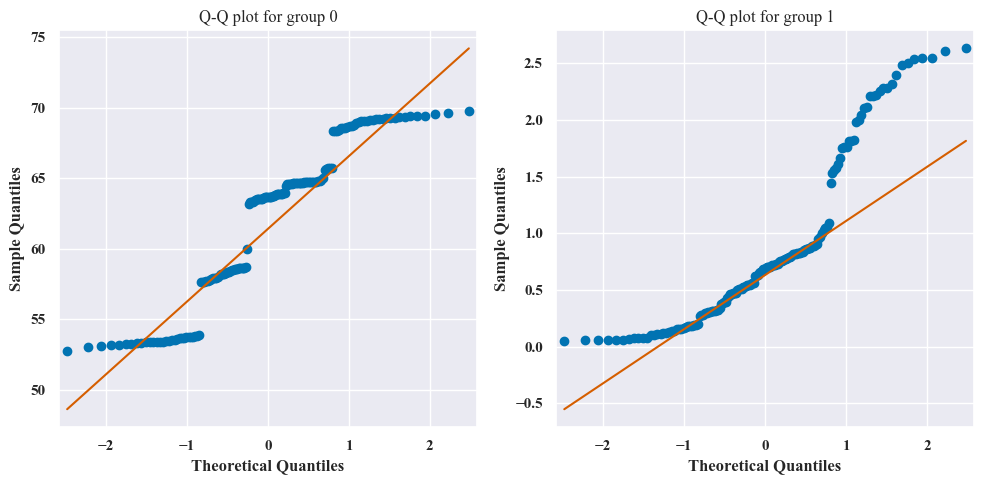

In [28]:
local_ml_df = temp_vs_energy_df.query("`training environment` == 'Local ML'")
test_assumptions(local_ml_df["temperature"], local_ml_df["energy"], nrows=1, ncols=2, figsize=(10, 5))

The visual assessment and the Shapiro-Wilk test indicate that the data is not normally distributed. Therefore, we perform the Spearman's rank correlation test.

#### Spearman's rank correlation test
The results of the correlation test show that there is a positive correlation between temperature and energy consumption. However, we observe different behaviors depending on the environment.

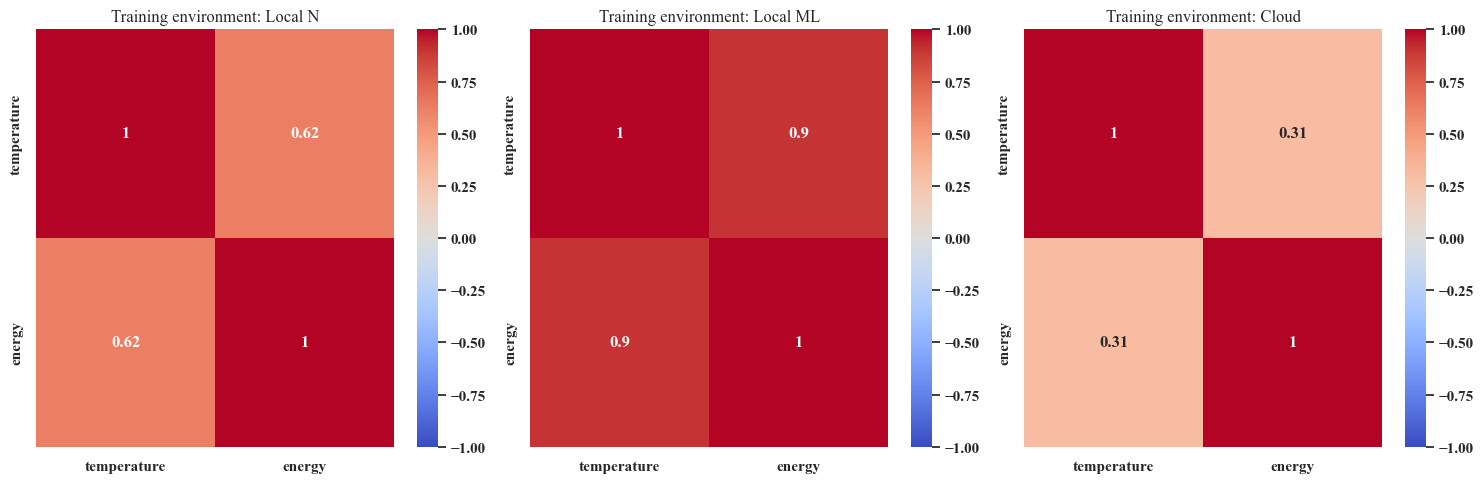

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, strategy in enumerate(TRAIN_STRATEGIES):
    data = temp_vs_energy_df.query("`training environment` == @strategy")[["temperature", "energy"]]

    corr = data.corr("spearman")
    ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, ax=axes[i], cmap="coolwarm")
    ax.set_title(f"Training environment: {strategy}")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "temperature-energy-correlation.pdf"))

### Impact of temperature on GPU usage

As with the energy consumption, we do not observe a particular correlation between temperature and GPU usage in a general view. However, when looking at the data for each environment separately, we there seems to be a positive correlation between temperature and GPU usage.

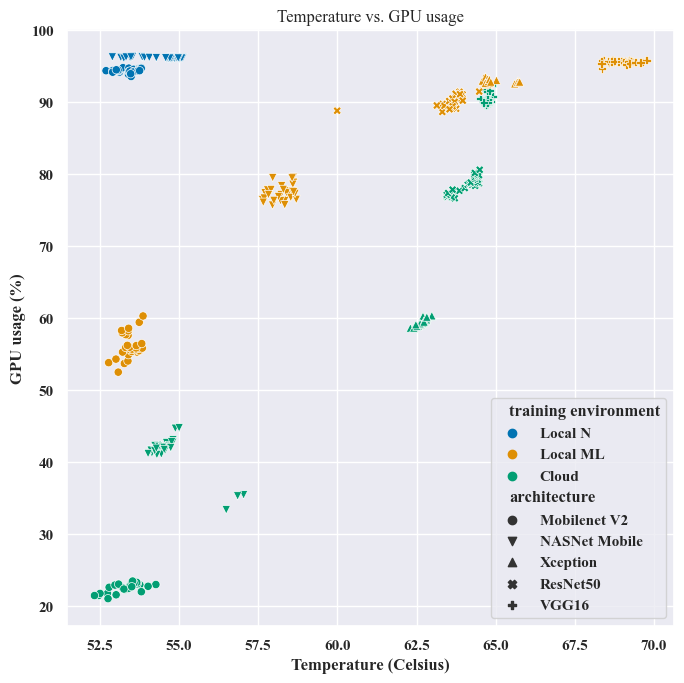

In [30]:
_, axes = plt.subplots(1, 1, figsize=((7, 7)))
ax = sns.scatterplot(
    temp_vs_energy_df,
    x="temperature",
    y="gpu_usage",
    ax=axes,
    style="architecture",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    markers=MARKERS,
)
ax.set_title("Temperature vs. GPU usage")
ax.set_xlabel("Temperature (Celsius)")
ax.set_ylabel("GPU usage (%)")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "temperature-gpu_usage-scatter.pdf"))

plt.show()

#### Test normality assumption
As in the previous correlation analysis, we check the normality of the data.

Shapiro test for normality of group 0: W = 0.7680411338806152 and p-value 9.210459407963875e-14
Shapiro test for normality of group 1: W = 0.8920393586158752 and p-value 8.995018063728821e-09
Levene test for equal variances: W = 222.901221310917 and p-value = 1.3288640601516237e-37


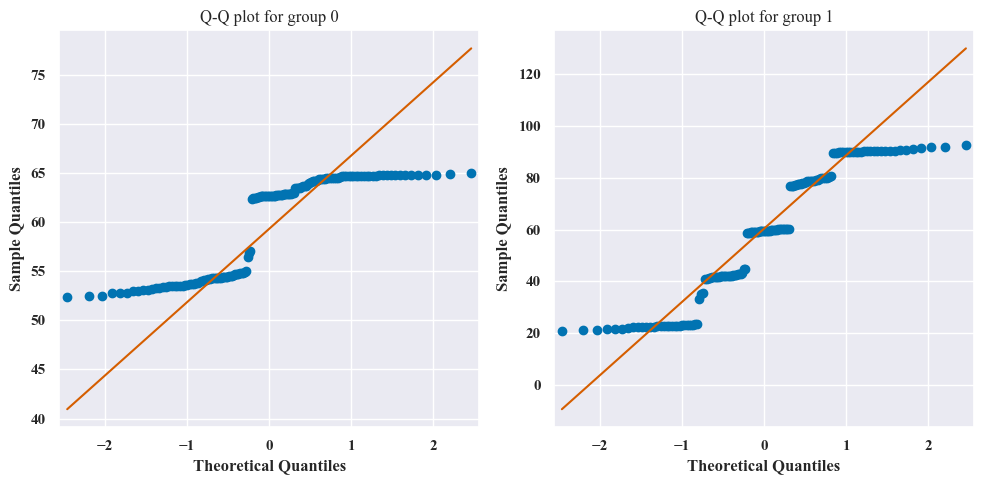

In [31]:
cloud_df = temp_vs_energy_df.query("`training environment` == 'Cloud'")
test_assumptions(cloud_df["temperature"], cloud_df["gpu_usage"], nrows=1, ncols=2, figsize=(10, 5))

Shapiro test for normality of group 0: W = 0.9090379476547241 and p-value 0.00028551919967867434
Shapiro test for normality of group 1: W = 0.7974491715431213 and p-value 1.1669445143525081e-07
Levene test for equal variances: W = 28.660322247087283 and p-value = 4.308962000689608e-07


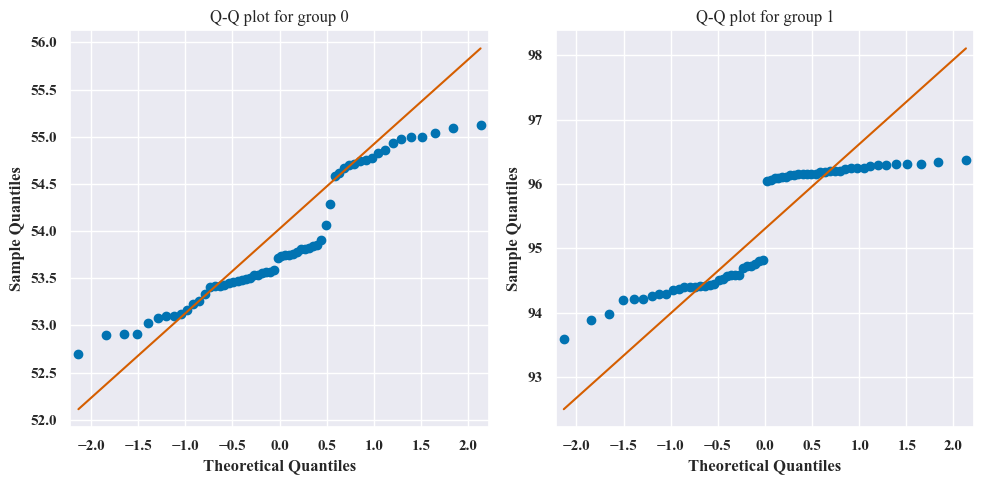

In [32]:
local_n_df = temp_vs_energy_df.query("`training environment` == 'Local N'")
test_assumptions(local_n_df["temperature"], local_n_df["gpu_usage"], nrows=1, ncols=2, figsize=(10, 5))

Shapiro test for normality of group 0: W = 0.9090379476547241 and p-value 0.00028551919967867434
Shapiro test for normality of group 1: W = 0.7974491715431213 and p-value 1.1669445143525081e-07
Levene test for equal variances: W = 28.660322247087283 and p-value = 4.308962000689608e-07


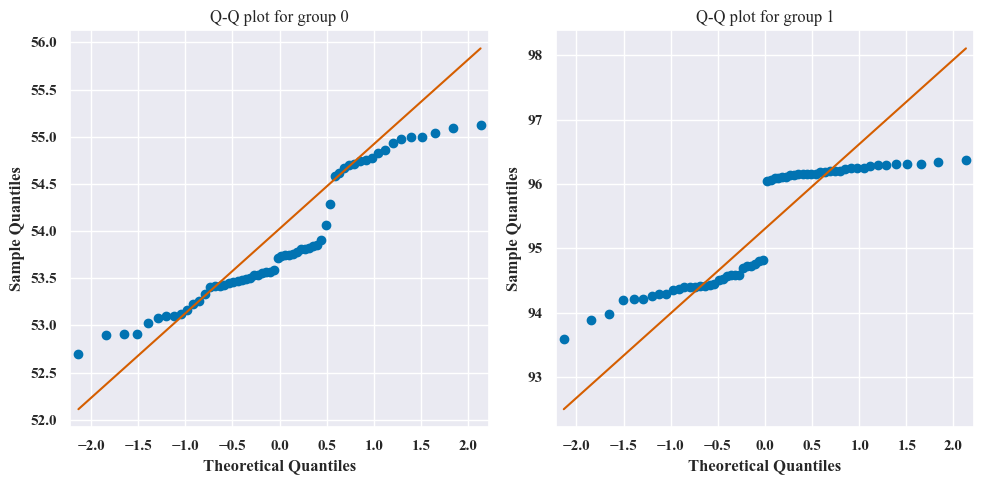

In [33]:
local_ml_df = temp_vs_energy_df.query("`training environment` == 'Local ML'")
test_assumptions(local_n_df["temperature"], local_n_df["gpu_usage"], nrows=1, ncols=2, figsize=(10, 5))

The visual assessment and the Shapiro-Wilk test indicate that the data is not normally distributed. Therefore, we perform the Spearman's rank correlation test.

#### Spearman's rank correlation test
The results of the correlation test show that there is a positive correlation between temperature and energy consumption. Moreover, we find a very strong correlation between temperature and GPU usage in the Local ML and Cloud environments.

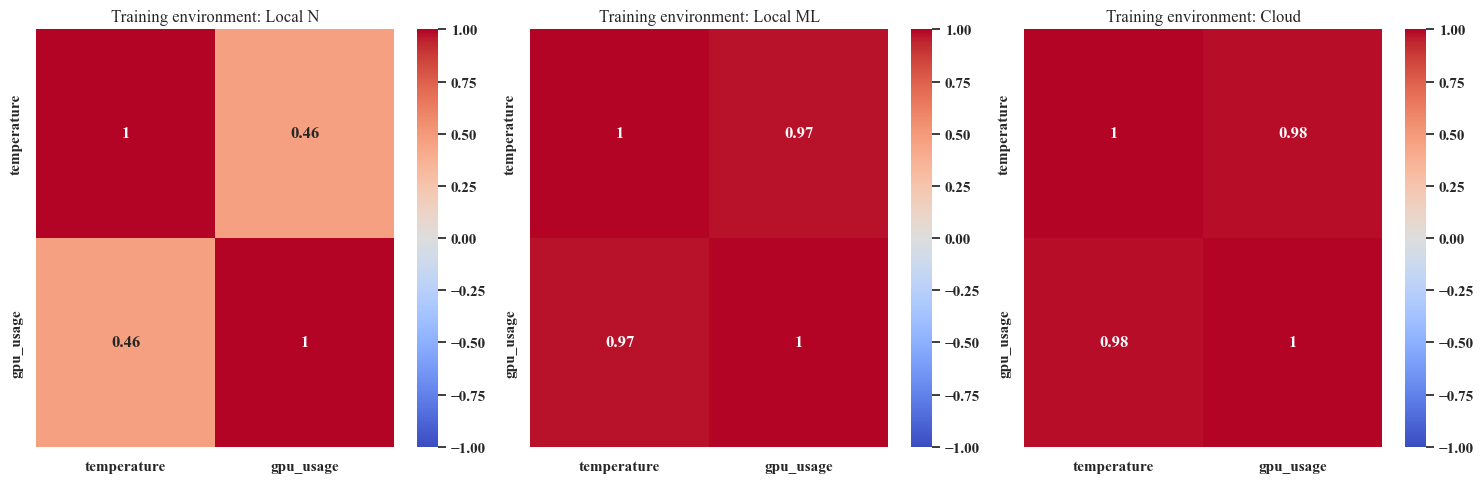

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, strategy in enumerate(TRAIN_STRATEGIES):
    data = temp_vs_energy_df.query("`training environment` == @strategy")[["temperature", "gpu_usage"]]
    corr = data.corr("spearman")
    # print(strategy)
    # print(corr, end="\n\n")
    ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, ax=axes[i], cmap="coolwarm")
    ax.set_title(f"Training environment: {strategy}")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "temperature-gpu_usage-correlation.pdf"))

### Comparison between model architectures and training environment
#### Energy comparison

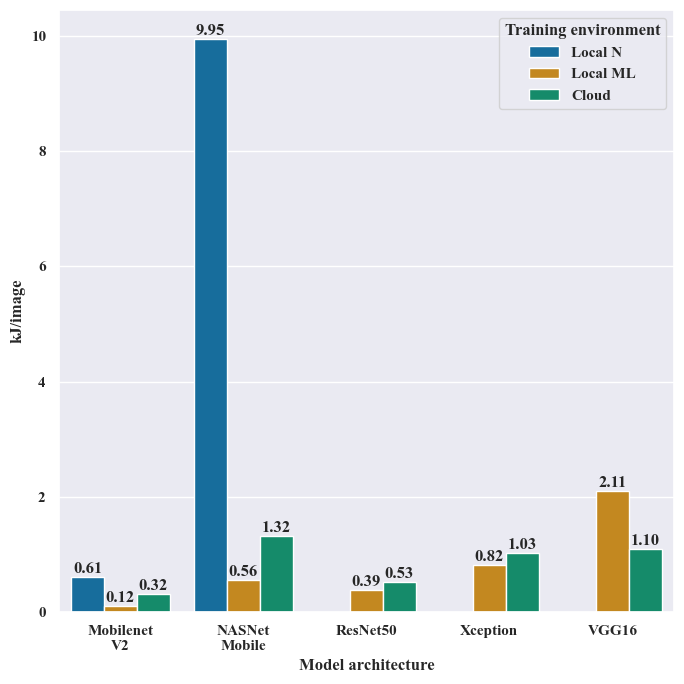

In [35]:
analysis_df_no_outliers = (
    pd.concat(
        [
            cloud_mobilenet,
            cloud_nasnet_no_gpu_outliers,
            cloud_xception,
            cloud_resnet50_no_gpu_outliers,
            cloud_vgg16_no_energy_outliers,
            local_n_mobilenet,
            local_n_nasnet,
            local_ml_mobilenet_no_gpu_outliers,
            local_ml_nasnet,
            local_ml_xception,
            local_ml_resnet50,
            local_ml_vgg16,
        ]
    )
    .query("`f1-score` > 0")
    .sort_values(by=["GFLOPs", "training environment", "architecture"], ascending=True)
    .reset_index(drop=True)
)

_, ax1 = plt.subplots(1, 1, figsize=((7, 7)))
_, ax = barplot(
    analysis_df_no_outliers,
    x="architecture",
    y="energy",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    estimator="median",
    xlabel="Model architecture",
    ylabel="kJ/image",
    barlabel=True,
    ax=ax1,
)
ax.legend(title="Training environment", loc="upper right")
labels = [label.get_text().replace(" ", "\n") for label in ax1.get_xticklabels()]
ax1.set_xticklabels(labels)

plt.savefig(os.path.join(FIGURES_DIR, "energy-comparison-full.pdf"))

##### Energy improvement within architectures

In [36]:
improvement = (
    cloud_nasnet_no_gpu_outliers.energy.median() - cloud_mobilenet.energy.median()
) / cloud_nasnet_no_gpu_outliers.energy.median()
print(f"Maximum improvement: {improvement}")

Maximum improvement: 0.760036880559132


In [37]:
improvement = (
    cloud_nasnet_no_gpu_outliers.energy.median() - cloud_vgg16_no_energy_outliers.energy.median()
) / cloud_nasnet_no_gpu_outliers.energy.median()
print(f"Minimum improvement: {improvement}")

Minimum improvement: 0.17205608876680256


##### Energy improvement within training strategies

In [38]:
improvement = (
    local_n_mobilenet.energy.median() - local_ml_mobilenet_no_gpu_outliers.energy.median()
) / local_n_mobilenet.energy.median()
print(f"Maximum improvement: {improvement}")

Maximum improvement: 0.8087101166931104


In [39]:
improvement = (local_n_mobilenet.energy.median() - cloud_mobilenet.energy.median()) / local_n_mobilenet.energy.median()
print(f"Minimum improvement: {improvement}")

Minimum improvement: 0.4761909131147304


##### Overall energy improvement

In [40]:
print_improvement(analysis_df_no_outliers, "energy")

Maximum improvement: 0.9883494999133446 (NASNet Mobile - Local N, Mobilenet V2 - Local ML)
Minimum improvement: 0.0465437895057198 (NASNet Mobile - Local ML, ResNet50 - Cloud)


#### GPU usage comparison

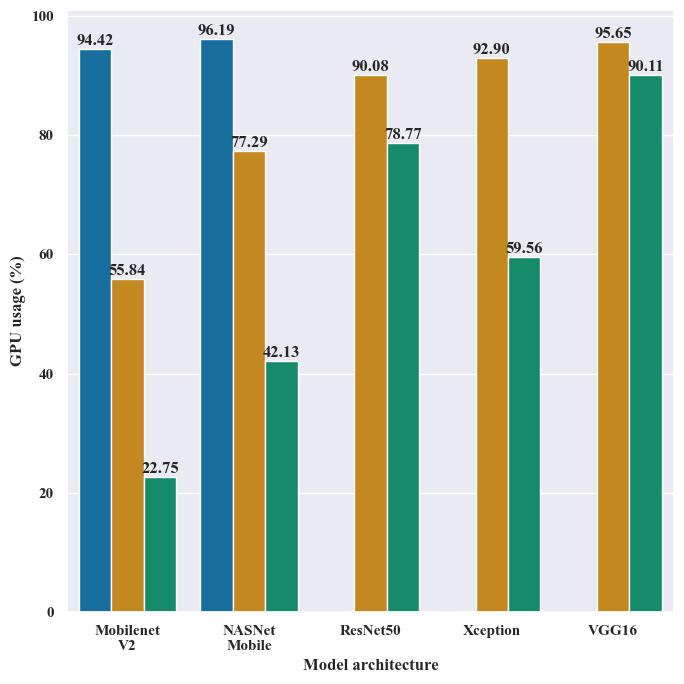

In [41]:
_, ax1 = plt.subplots(1, 1, figsize=((7, 7)))
_, ax = barplot(
    analysis_df_no_outliers,
    x="architecture",
    y="gpu_usage",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    estimator="median",
    xlabel="Model architecture",
    ylabel="GPU usage (%)",
    barlabel=True,
    ax=ax1,
)

labels = [label.get_text().replace(" ", "\n") for label in ax1.get_xticklabels()]
ax1.set_xticklabels(labels)

ax.get_legend().remove()
plt.savefig(os.path.join(FIGURES_DIR, "gpu-comparison-full.pdf"))

#### Training time comparison

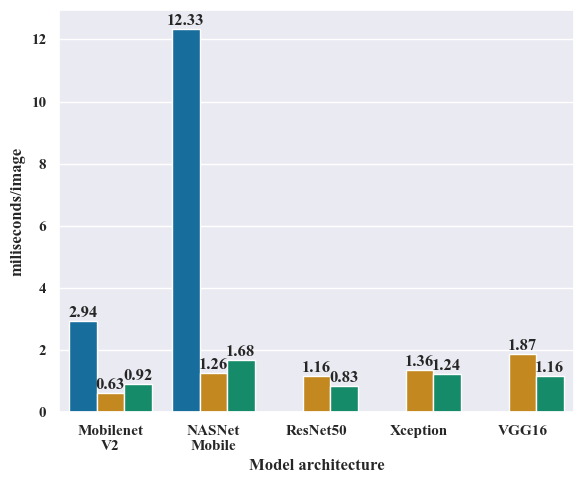

In [42]:
_, ax = barplot(
    analysis_df_no_outliers,
    x="architecture",
    y="normalized duration",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    estimator="median",
    xlabel="Model architecture",
    ylabel="miliseconds/image",
    barlabel=True,
    figsize=(6, 5),
)

labels = [label.get_text().replace(" ", "\n") for label in ax.get_xticklabels()]
ax.set_xticklabels(labels)

ax.get_legend().remove()

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "training-time-comparison-full.pdf"))

#### F1-score comparison

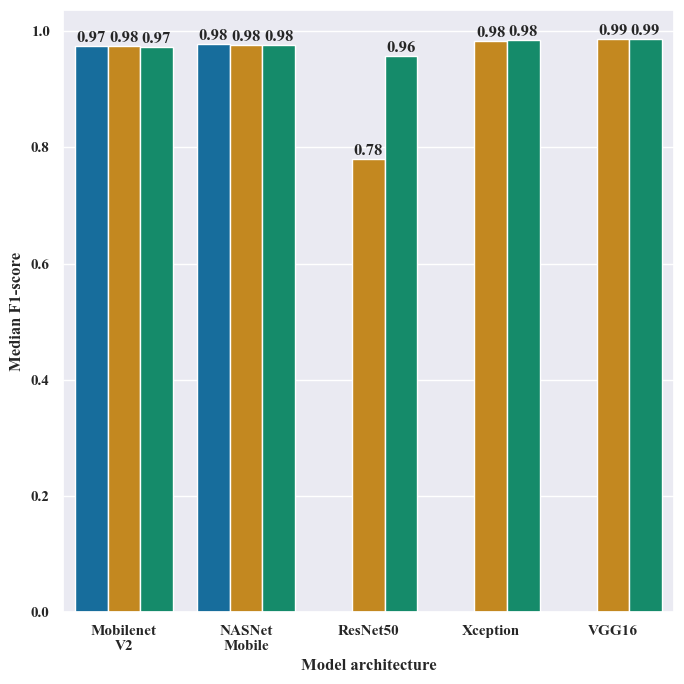

In [43]:
_, ax = barplot(
    analysis_df_no_outliers,
    x="architecture",
    y="f1-score",
    xlabel="Model architecture",
    ylabel="Median F1-score",
    estimator="median",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    barlabel=True,
    figname="local-v2-f1score-comparison.pdf",
    figsize=(7, 7),
)

ax.get_legend().remove()
labels = [label.get_text().replace(" ", "\n") for label in ax.get_xticklabels()]
ax.set_xticklabels(labels)

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "accuracy-comparison.pdf"))

##### F1-score improvement within architectures

In [44]:
improvement = (
    cloud_vgg16_no_energy_outliers["f1-score"].median() - cloud_resnet50_no_gpu_outliers["f1-score"].median()
) / cloud_vgg16_no_energy_outliers["f1-score"].median()
print(f"Maximum improvement: {improvement}")
1 - improvement

Maximum improvement: 0.030557545836576758


0.9694424541634232

In [45]:
improvement = (
    cloud_vgg16_no_energy_outliers["f1-score"].median() - cloud_xception["f1-score"].median()
) / cloud_vgg16_no_energy_outliers["f1-score"].median()
print(f"Minimum improvement: {improvement}")
1 - improvement

Minimum improvement: 0.0025926907201687037


0.9974073092798313

##### Overall F1-score improvement

In [46]:
print_improvement(analysis_df_no_outliers, "f1-score")

Maximum improvement: 0.20913895287181744 (VGG16 - Cloud, ResNet50 - Local ML)
Minimum improvement: 0.00035691008086339204 (NASNet Mobile - Local ML, Mobilenet V2 - Local ML)


### Trade-off between accuracy and energy

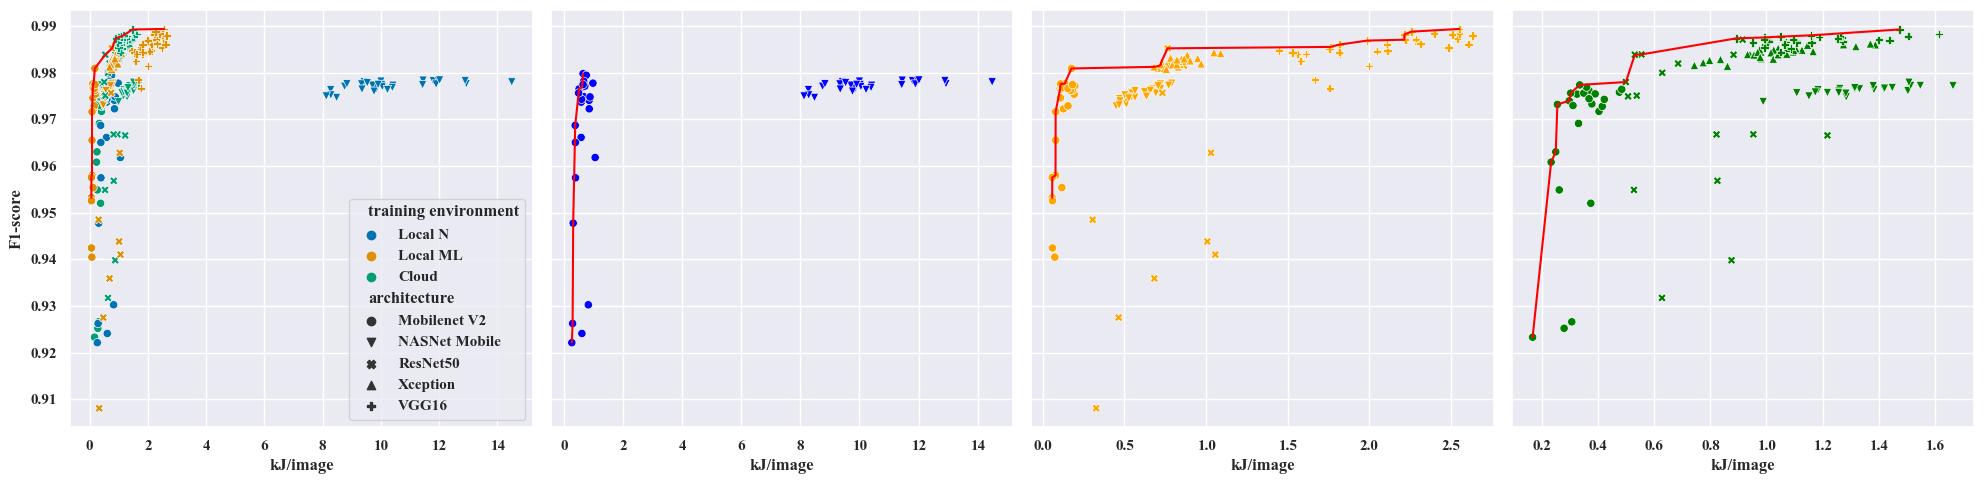

In [47]:
_, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

colors = {"Cloud": "green", "Local N": "blue", "Local ML": "orange"}

tradeoff_data = analysis_df_no_outliers.query("`f1-score` >= 0.9 & energy < 100")
costs = tradeoff_data[["energy", "f1-score"]].to_numpy()
pareto = is_pareto_efficient(costs)
sns.scatterplot(
    tradeoff_data,
    x="energy",
    y="f1-score",
    style="architecture",
    markers=MARKERS,
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    ax=axes[0],
)
sns.lineplot(tradeoff_data.loc[pareto], x="energy", y="f1-score", ax=axes[0], color="red")
axes[0].grid(visible=True, axis="both")

axes[0].set_xlabel("kJ/image")
axes[0].set_ylabel("F1-score")

for i, strategy in enumerate(TRAIN_STRATEGIES, 1):
    data = tradeoff_data.query("`training environment` == @strategy")
    costs = data[["energy", "f1-score"]].to_numpy()
    pareto = is_pareto_efficient(costs)
    sns.scatterplot(
        data, x="energy", y="f1-score", style="architecture", markers=MARKERS, color=colors[strategy], ax=axes[i]
    )
    sns.lineplot(data.loc[pareto], x="energy", y="f1-score", ax=axes[i], color="red")

    axes[i].get_legend().remove()
    axes[i].set_xlabel("kJ/image")

    axes[i].grid(visible=True, axis="both")


if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "accuracy-energy-comparison.pdf"))

#### Correlation between F1-score and energy
Looking at the Spearman $\rho$ correlation coefficient, we observe that there is a strong positive correlation between F1-score and energy consumption.

In [48]:
results_df = pd.DataFrame(columns=["training environment", "rho", "p-value"])

for strategy in TRAIN_STRATEGIES:
    data = analysis_df_no_outliers.query("`training environment` == @strategy")
    if not data.empty:
        # print(strategy, architecture)
        corr = stats.spearmanr(data.energy, data["f1-score"], alternative="greater")
        # print(corr)
        # print()
        results_df.loc[len(results_df)] = [strategy, corr[0], corr[1]]
results_df

,training environment,rho,p-value
0,Local N,0.688858,5.854752e-10
1,Local ML,0.809838,1.237585e-36
2,Cloud,0.601370,1.972290e-15


### Energy vs. GPU usage

In [49]:
cloud_energy_vs_gpu_usage_df = pd.concat(
    [
        cloud_mobilenet,
        cloud_nasnet_no_gpu_outliers,
        cloud_xception,
        cloud_resnet50_no_gpu_outliers,
        cloud_vgg16_no_energy_outliers,
    ]
)
local_n_energy_vs_gpu_usage_df = pd.concat(
    [
        local_n_mobilenet,
        local_n_nasnet,
    ]
)

local_ml_energy_vs_gpu_usage_df = pd.concat(
    [
        local_ml_mobilenet_no_gpu_outliers,
        local_ml_nasnet,
        local_ml_xception,
        local_ml_resnet50,
        local_ml_vgg16,
    ]
)

From a general perspective, we do not observe a clear correlation between energy consumption and GPU usage.

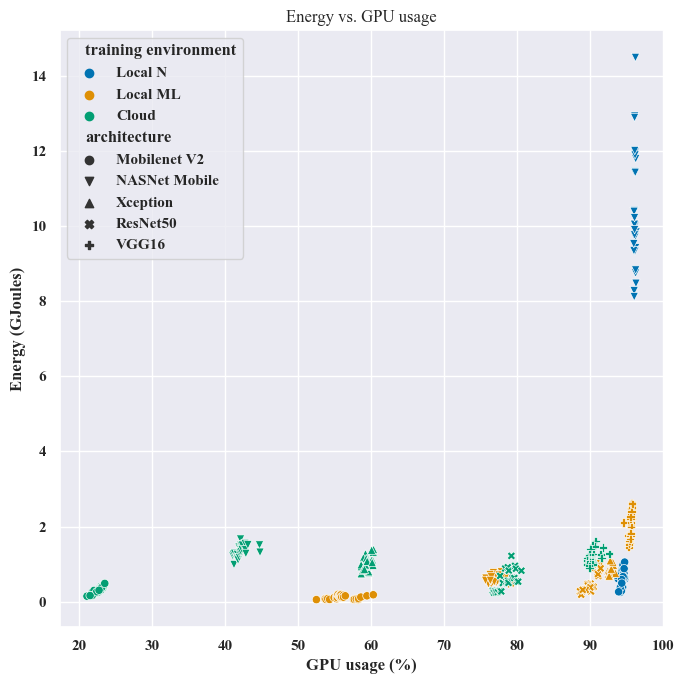

In [50]:
energy_vs_gpu_usage_df = pd.concat(
    [local_n_energy_vs_gpu_usage_df, local_ml_energy_vs_gpu_usage_df, cloud_energy_vs_gpu_usage_df]
)

_, axis = plt.subplots(1, 1, figsize=((7, 7)))
ax = sns.scatterplot(
    energy_vs_gpu_usage_df,
    y="energy",
    x="gpu_usage",
    ax=axis,
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    style="architecture",
    markers=MARKERS,
    legend="brief",
)
ax.set_title("Energy vs. GPU usage")
ax.set_ylabel("Energy (GJoules)")
ax.set_xlabel("GPU usage (%)")
plt.show()

#### Correlation between energy and GPU usage

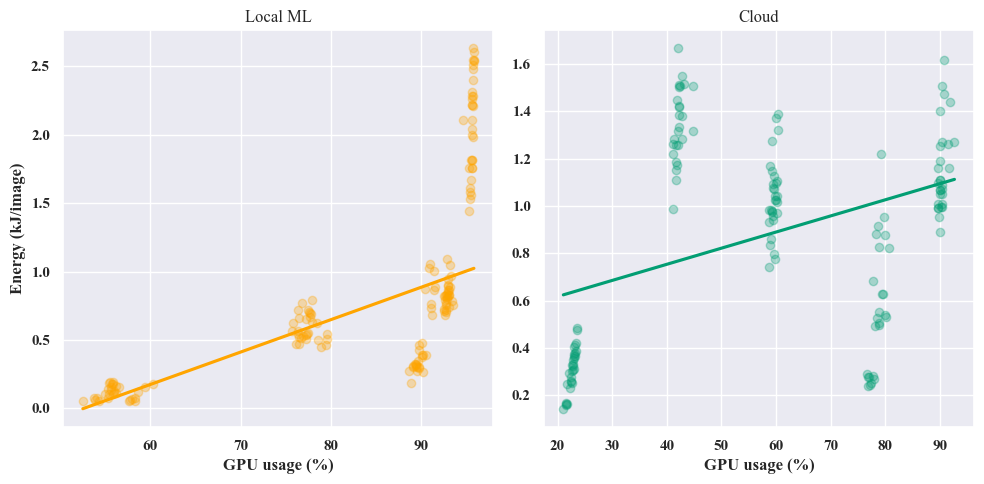

In [51]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
tmp = local_ml_energy_vs_gpu_usage_df.copy()
tmp.energy = local_ml_energy_vs_gpu_usage_df.energy.apply(np.log)
ax = sns.regplot(
    local_ml_energy_vs_gpu_usage_df,
    y="energy",
    x="gpu_usage",
    ax=ax0,
    color=COLORS["Local ML"],
    ci=None,
    robust=True,
    scatter_kws={"alpha": 0.3},
)
ax.set_title("Local ML")
ax.set_ylabel("Energy (kJ/image)")
ax.set_xlabel("GPU usage (%)")

tmp = cloud_energy_vs_gpu_usage_df.copy()
tmp.energy = cloud_energy_vs_gpu_usage_df.energy.apply(np.log)
ax = sns.regplot(
    cloud_energy_vs_gpu_usage_df,
    y="energy",
    x="gpu_usage",
    ax=ax1,
    color=COLORS["Cloud"],
    ci=None,
    robust=True,
    scatter_kws={"alpha": 0.3},
)
ax.set_title("Cloud")
ax.set_ylabel(None)
ax.set_xlabel("GPU usage (%)")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "energy-gpu-regression.pdf"))

In [52]:
stats.spearmanr(
    local_ml_energy_vs_gpu_usage_df.energy, local_ml_energy_vs_gpu_usage_df.gpu_usage, alternative="greater"
)

SignificanceResult(statistic=0.9060682481427565, pvalue=3.3548564757812096e-58)

In [53]:
stats.spearmanr(cloud_energy_vs_gpu_usage_df.energy, cloud_energy_vs_gpu_usage_df.gpu_usage, alternative="greater")

SignificanceResult(statistic=0.34563425247643836, pvalue=1.4410764558606983e-05)

## Statistical significance analysis

### RQ1 - What is the impact of model architecture on a computer vision system with respect to energy efficiency and model correctness?

In [54]:
rq1_df = pd.concat(
    [
        cloud_mobilenet,
        cloud_nasnet_no_gpu_outliers,
        cloud_xception,
        cloud_resnet50_no_gpu_outliers.query("`f1-score` > 0"),
        cloud_vgg16_no_energy_outliers,
    ]
)
rq1_df.energy = rq1_df.energy.apply(np.sqrt)

#### RQ1.1 - How do DL architectures compare in terms of energy efficiency?

##### Energy
First we test the assumption of normality and homogeneity of the data. After applying a square root transformation to the energy data, we observe that the data is normally distributed. However, the data is not homogenous. Although the Shapiro-Wilk test indicates that the VGG16 data is not normally distributed, seeing the Q-Q plot we consider that the assumption of normality is met. Therefore, we perform a Welch's ANOVA test.

Shapiro test for normality of group 0: W = 0.9453985095024109 and p-value 0.12715919315814972
Shapiro test for normality of group 1: W = 0.9793034195899963 and p-value 0.8588094711303711
Shapiro test for normality of group 2: W = 0.9683184623718262 and p-value 0.4942511022090912
Shapiro test for normality of group 3: W = 0.9237625598907471 and p-value 0.062449581921100616
Shapiro test for normality of group 4: W = 0.9205285906791687 and p-value 0.03144731745123863
Levene test for equal variances: W = 9.021514368016463 and p-value = 1.7316157836624372e-06


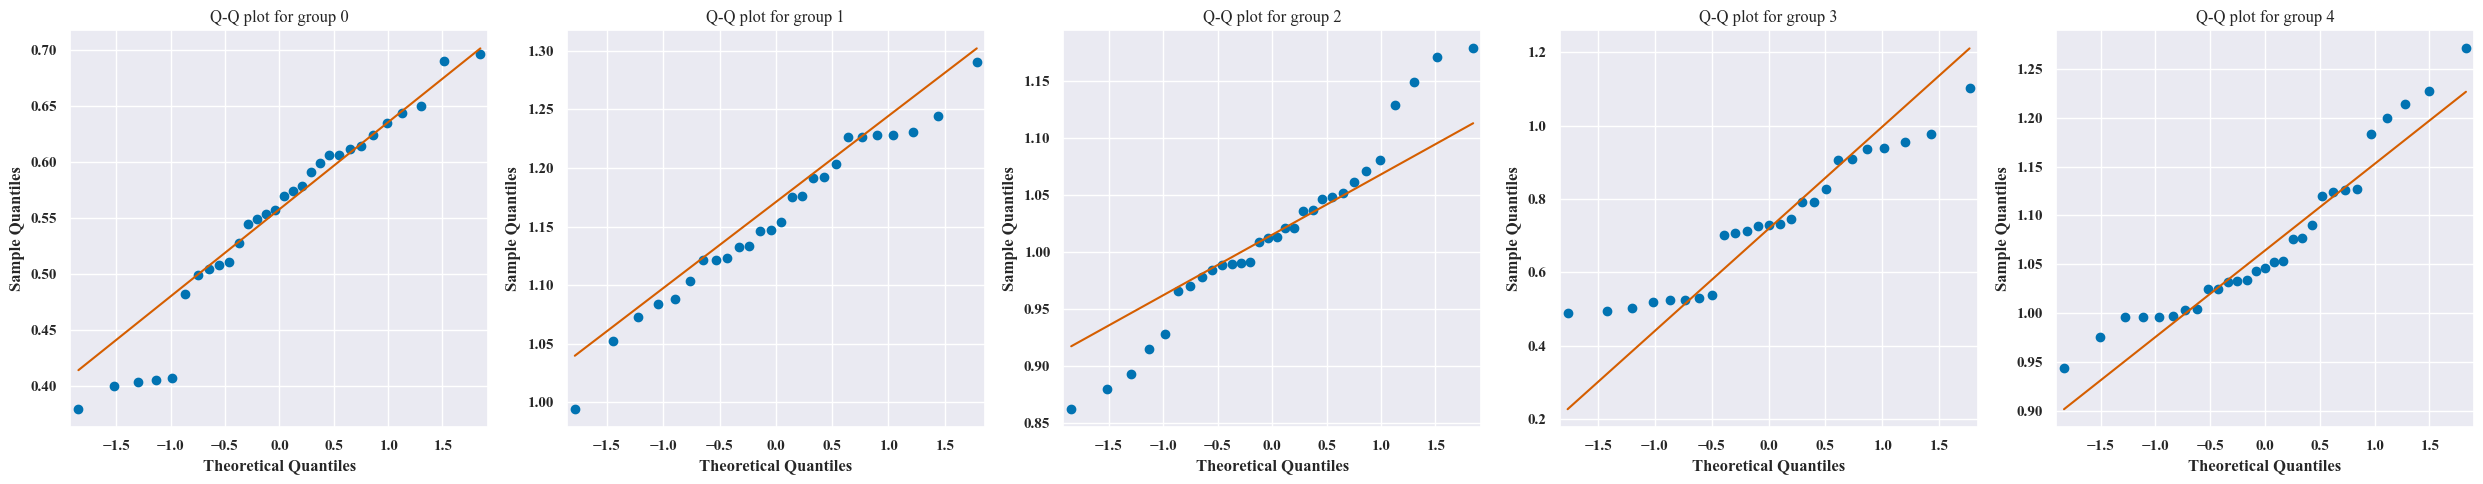

In [55]:
dependent_variable = "energy"
independent_variable = "architecture"

test_assumptions(
    rq1_df.query("architecture == 'Mobilenet V2'")[dependent_variable],
    rq1_df.query("architecture == 'NASNet Mobile'")[dependent_variable],
    rq1_df.query("architecture == 'Xception'")[dependent_variable],
    rq1_df.query("architecture == 'ResNet50'")[dependent_variable],
    rq1_df.query("architecture == 'VGG16'")[dependent_variable],
    nrows=1,
    ncols=5,
    figsize=(25, 5),
)

###### Welch's ANOVA test

In [56]:
pg.welch_anova(rq1_df, dv=dependent_variable, between=independent_variable)

,Source,ddof1,ddof2,F,p-unc,np2
0,architecture,4,65.686399,239.092001,2.251419e-38,0.83038


###### Games-Howell post-hoc test

In [57]:
pg.pairwise_gameshowell(rq1_df, dv=dependent_variable, between=independent_variable)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Mobilenet V2,NASNet Mobile,0.550677,1.157122,-0.606444,0.020835,-29.107231,53.593212,0.000000e+00,-7.562888
1,Mobilenet V2,ResNet50,0.550677,0.732657,-0.181980,0.039594,-4.596141,33.069304,5.427166e-04,-1.300386
2,Mobilenet V2,VGG16,0.550677,1.072180,-0.521503,0.022117,-23.578841,56.990847,0.000000e+00,-6.054216
3,Mobilenet V2,Xception,0.550677,1.015404,-0.464726,0.021399,-21.716779,57.419980,0.000000e+00,-5.534427
4,NASNet Mobile,ResNet50,1.157122,0.732657,0.424465,0.038702,10.967624,30.541885,3.998379e-11,3.070524
5,NASNet Mobile,VGG16,1.157122,1.072180,0.084942,0.020477,4.148136,52.704351,1.117185e-03,1.093137
6,NASNet Mobile,Xception,1.157122,1.015404,0.141718,0.019699,7.194029,53.991342,1.975243e-08,1.882509
7,ResNet50,VGG16,0.732657,1.072180,-0.339523,0.039407,-8.615829,32.527465,6.477481e-09,-2.434831
8,ResNet50,Xception,0.732657,1.015404,-0.282747,0.039008,-7.248348,31.463764,3.305002e-07,-2.061786
9,VGG16,Xception,1.072180,1.015404,0.056776,0.021051,2.697051,56.561373,6.695723e-02,0.693712


###### Kruskal-Wallis test

In [58]:
result_rq11 = pg.kruskal(rq1_df, dv=dependent_variable, between=independent_variable)
result_rq11

,Source,ddof1,H,p-unc
Kruskal,architecture,4,107.883286,2.057519e-22


###### Eta-squared measure

In [59]:
eta_squared(result_rq11["H"].item(), rq1_df[independent_variable].nunique(), rq1_df.shape[0])

0.7695058196479581

###### Dunn's test

In [60]:
p_values = sp.posthoc_dunn(
    rq1_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm", sort=True
)

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,Mobilenet V2,NASNet Mobile,ResNet50,VGG16,Xception
Mobilenet V2,False,True,False,True,True
NASNet Mobile,True,False,True,False,True
ResNet50,False,True,False,True,True
VGG16,True,False,True,False,False
Xception,True,True,True,False,False


In [61]:
mobilenet_v2 = rq1_df[dependent_variable][rq1_df["architecture"] == "Mobilenet V2"]
nasnet_mobile = rq1_df[dependent_variable][rq1_df["architecture"] == "NASNet Mobile"]
xception = rq1_df[dependent_variable][rq1_df["architecture"] == "Xception"]
resnet50 = rq1_df[dependent_variable][rq1_df["architecture"] == "ResNet50"]
vgg16 = rq1_df[dependent_variable][rq1_df["architecture"] == "VGG16"]

print(f"Mobilenet V2 - NASNet Mobile effect size: {cliffs_delta(mobilenet_v2, nasnet_mobile)}")
print(f"Mobilenet V2 - Xception effect size: {cliffs_delta(mobilenet_v2, xception)}")
print(f"Mobilenet V2 - ResNet50 effect size: {cliffs_delta(mobilenet_v2, resnet50)}")
print(f"Mobilenet V2 - VGG16 effect size: {cliffs_delta(mobilenet_v2, vgg16)}")
print(f"NASNet Mobile - Xception effect size: {cliffs_delta(nasnet_mobile, xception)}")
print(f"NASNet Mobile - ResNet50 effect size: {cliffs_delta(nasnet_mobile, resnet50)}")
print(f"NASNet Mobile - VGG16 effect size: {cliffs_delta(nasnet_mobile, vgg16)}")
print(f"Xception - ResNet50 effect size: {cliffs_delta(xception, resnet50)}")
print(f"Xception - VGG16 effect size: {cliffs_delta(xception, vgg16)}")
print(f"ResNet50 - VGG16 effect size: {cliffs_delta(resnet50, vgg16)}")

Mobilenet V2 - NASNet Mobile effect size: (-1.0, 'large')
Mobilenet V2 - Xception effect size: (-1.0, 'large')
Mobilenet V2 - ResNet50 effect size: (-0.5493333333333333, 'large')
Mobilenet V2 - VGG16 effect size: (-1.0, 'large')
NASNet Mobile - Xception effect size: (0.823076923076923, 'large')
NASNet Mobile - ResNet50 effect size: (0.9815384615384616, 'large')
NASNet Mobile - VGG16 effect size: (0.5755968169761273, 'large')
Xception - ResNet50 effect size: (0.856, 'large')
Xception - VGG16 effect size: (-0.3724137931034483, 'medium')
ResNet50 - VGG16 effect size: (-0.9365517241379311, 'large')


##### GPU usage
In this case, we observe that the data is not normally distributed. Therefore, we take the results from the Kruskal-Wallis test as the relevant ones.

Shapiro test for normality of group 0: W = 0.9209879040718079 and p-value 0.028453435748815536
Shapiro test for normality of group 1: W = 0.8396124243736267 and p-value 0.0009005153551697731
Shapiro test for normality of group 2: W = 0.9507325291633606 and p-value 0.17686785757541656
Shapiro test for normality of group 3: W = 0.9611562490463257 and p-value 0.43798255920410156
Shapiro test for normality of group 4: W = 0.8111292719841003 and p-value 0.00013311690418049693
Levene test for equal variances: W = 3.927364835728561 and p-value = 0.0047652269170281435


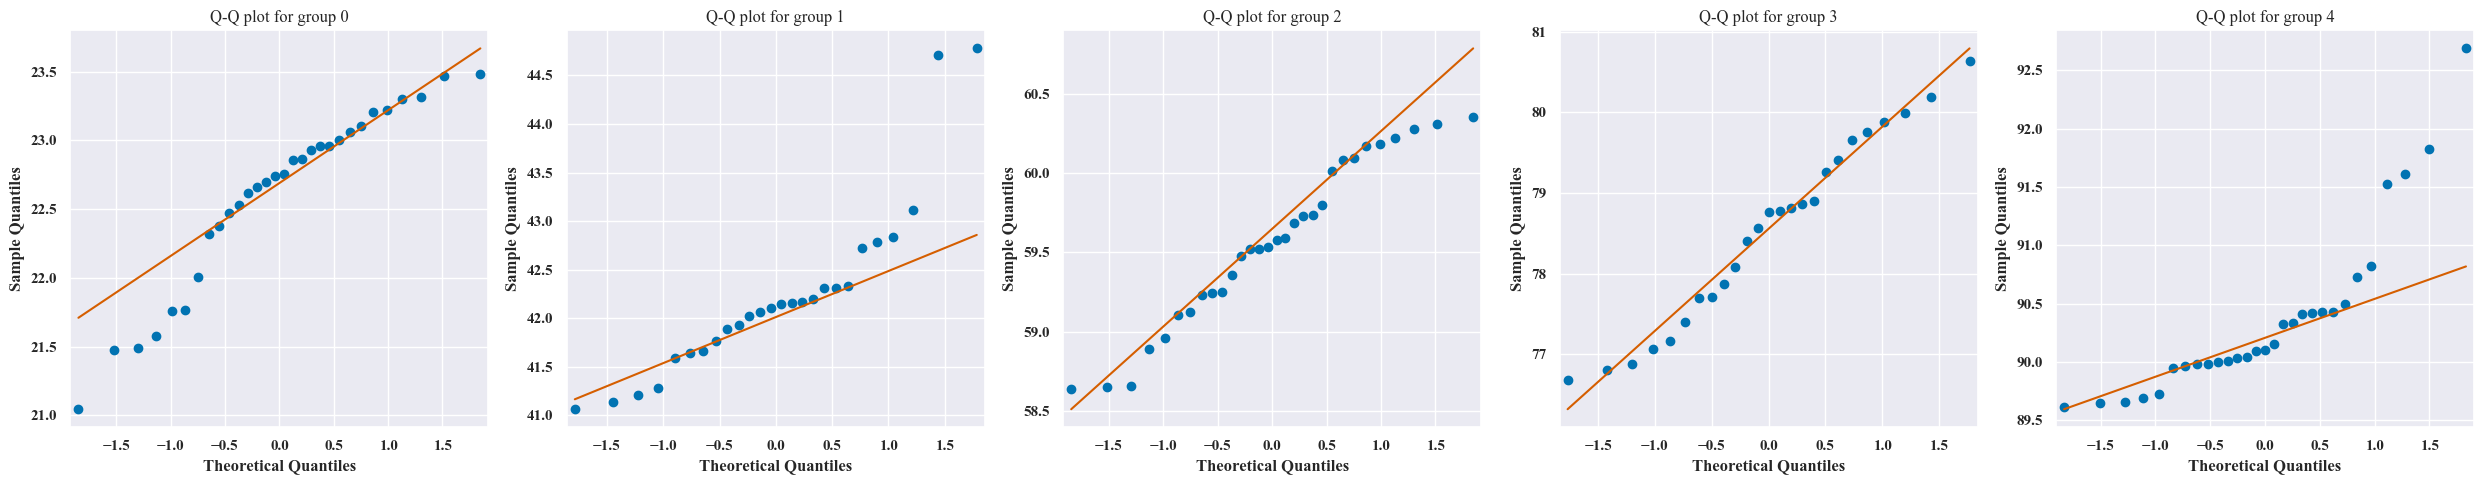

In [62]:
dependent_variable = "gpu_usage"

test_assumptions(
    rq1_df.query("architecture == 'Mobilenet V2'")[dependent_variable],
    rq1_df.query("architecture == 'NASNet Mobile'")[dependent_variable],
    rq1_df.query("architecture == 'Xception'")[dependent_variable],
    rq1_df.query("architecture == 'ResNet50'")[dependent_variable],
    rq1_df.query("architecture == 'VGG16'")[dependent_variable],
    nrows=1,
    ncols=5,
    figsize=(25, 5),
)

###### Welch's ANOVA test

In [63]:
pg.welch_anova(rq1_df, dv=dependent_variable, between=independent_variable)

,Source,ddof1,ddof2,F,p-unc,np2
0,architecture,4,64.528362,39124.489648,2.039769e-108,0.998974


###### Games-Howell post-hoc test

In [64]:
pg.pairwise_gameshowell(rq1_df, dv=dependent_variable, between=independent_variable)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Mobilenet V2,NASNet Mobile,22.601064,42.229507,-19.628442,0.213720,-91.841858,44.802625,0.000000e+00,-24.827785
1,Mobilenet V2,ResNet50,22.601064,78.530723,-55.929658,0.260412,-214.773610,36.300415,3.330669e-16,-60.152857
2,Mobilenet V2,VGG16,22.601064,90.369925,-67.768860,0.179230,-378.111412,56.012035,0.000000e+00,-97.329846
3,Mobilenet V2,Xception,22.601064,59.566237,-36.965173,0.152265,-242.769109,55.184596,1.332268e-15,-61.868653
4,NASNet Mobile,ResNet50,42.229507,78.530723,-36.301216,0.291667,-124.461305,45.421060,0.000000e+00,-34.493022
5,NASNet Mobile,VGG16,42.229507,90.369925,-48.140418,0.222212,-216.641542,47.749359,0.000000e+00,-58.399421
6,NASNet Mobile,Xception,42.229507,59.566237,-17.336730,0.201096,-86.211309,38.587603,0.000000e+00,-23.630659
7,ResNet50,VGG16,78.530723,90.369925,-11.839202,0.267426,-44.270978,38.988323,0.000000e+00,-12.310932
8,ResNet50,Xception,78.530723,59.566237,18.964486,0.250155,75.810797,31.966943,0.000000e+00,21.527565
9,VGG16,Xception,90.369925,59.566237,30.803688,0.163971,187.860129,50.777594,2.176037e-14,48.540027


###### Kruskal-Wallis test

In [65]:
result_rq11 = pg.kruskal(rq1_df, dv=dependent_variable, between=independent_variable)
result_rq11

,Source,ddof1,H,p-unc
Kruskal,architecture,4,133.354103,7.463900e-28


###### Eta-squared measure

In [66]:
eta_squared(result_rq11["H"].item(), rq1_df[independent_variable].nunique(), rq1_df.shape[0])

0.9581785432849268

###### Dunn's test

In [67]:
p_values = sp.posthoc_dunn(
    rq1_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm", sort=True
)

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,Mobilenet V2,NASNet Mobile,ResNet50,VGG16,Xception
Mobilenet V2,False,True,True,True,True
NASNet Mobile,True,False,True,True,True
ResNet50,True,True,False,True,True
VGG16,True,True,True,False,True
Xception,True,True,True,True,False


In [68]:
mobilenet_v2 = rq1_df[dependent_variable][rq1_df["architecture"] == "Mobilenet V2"]
nasnet_mobile = rq1_df[dependent_variable][rq1_df["architecture"] == "NASNet Mobile"]
xception = rq1_df[dependent_variable][rq1_df["architecture"] == "Xception"]
resnet50 = rq1_df[dependent_variable][rq1_df["architecture"] == "ResNet50"]
vgg16 = rq1_df[dependent_variable][rq1_df["architecture"] == "VGG16"]

print(f"Mobilenet V2 - NASNet Mobile effect size: {cliffs_delta(mobilenet_v2, nasnet_mobile)}")
print(f"Mobilenet V2 - Xception effect size: {cliffs_delta(mobilenet_v2, xception)}")
print(f"Mobilenet V2 - ResNet50 effect size: {cliffs_delta(mobilenet_v2, resnet50)}")
print(f"Mobilenet V2 - VGG16 effect size: {cliffs_delta(mobilenet_v2, vgg16)}")
print(f"NASNet Mobile - Xception effect size: {cliffs_delta(nasnet_mobile, xception)}")
print(f"NASNet Mobile - ResNet50 effect size: {cliffs_delta(nasnet_mobile, resnet50)}")
print(f"NASNet Mobile - VGG16 effect size: {cliffs_delta(nasnet_mobile, vgg16)}")
print(f"Xception - ResNet50 effect size: {cliffs_delta(xception, resnet50)}")
print(f"Xception - VGG16 effect size: {cliffs_delta(xception, vgg16)}")
print(f"ResNet50 - VGG16 effect size: {cliffs_delta(resnet50, vgg16)}")

Mobilenet V2 - NASNet Mobile effect size: (-1.0, 'large')
Mobilenet V2 - Xception effect size: (-1.0, 'large')
Mobilenet V2 - ResNet50 effect size: (-1.0, 'large')
Mobilenet V2 - VGG16 effect size: (-1.0, 'large')
NASNet Mobile - Xception effect size: (-1.0, 'large')
NASNet Mobile - ResNet50 effect size: (-1.0, 'large')
NASNet Mobile - VGG16 effect size: (-1.0, 'large')
Xception - ResNet50 effect size: (-1.0, 'large')
Xception - VGG16 effect size: (-1.0, 'large')
ResNet50 - VGG16 effect size: (-1.0, 'large')


#### RQ1.2 - Do gains in correctness achieved by energy-greedy architectures justify their increased energy consumption?

As we clearly see from the Q-Q plots, the F1-score data is not normally distributed. Therefore, we perform a Kruskal-Wallis test.

Shapiro test for normality of group 0: W = 0.5614897012710571 and p-value 2.5521618596258122e-08
Shapiro test for normality of group 1: W = 0.9575476050376892 and p-value 0.3455858528614044
Shapiro test for normality of group 2: W = 0.9610384106636047 and p-value 0.3292081356048584
Shapiro test for normality of group 3: W = 0.6999666094779968 and p-value 7.28050463294494e-06
Shapiro test for normality of group 4: W = 0.9783178567886353 and p-value 0.7939429879188538
Levene test for equal variances: W = 10.701102253559972 and p-value = 1.456111281113618e-07


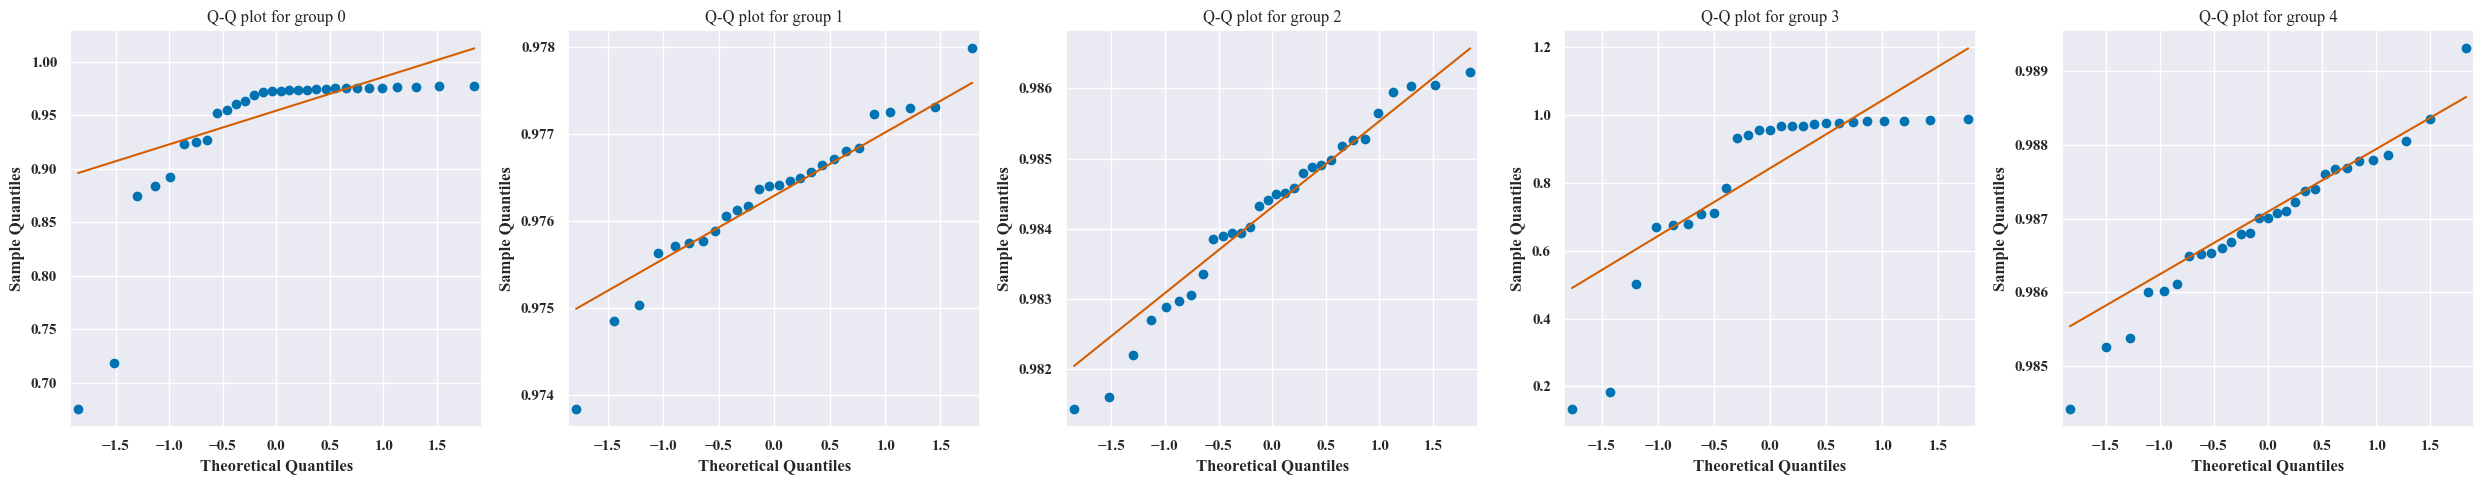

In [69]:
dependent_variable = "f1-score"

test_assumptions(
    rq1_df.query("architecture == 'Mobilenet V2'")[dependent_variable],
    rq1_df.query("architecture == 'NASNet Mobile'")[dependent_variable],
    rq1_df.query("architecture == 'Xception'")[dependent_variable],
    rq1_df.query("architecture == 'ResNet50'")[dependent_variable],
    rq1_df.query("architecture == 'VGG16'")[dependent_variable],
    nrows=1,
    ncols=5,
    figsize=(25, 5),
)

##### Kruskal-Wallis test

In [70]:
result_rq12 = pg.kruskal(rq1_df, dv=dependent_variable, between=independent_variable)
result_rq12

,Source,ddof1,H,p-unc
Kruskal,architecture,4,108.292997,1.682645e-22


##### Eta-squared measure

In [71]:
eta_squared(result_rq12["H"].item(), rq1_df[independent_variable].nunique(), rq1_df.shape[0])

0.772540717754484

##### Dunn's test

In [72]:
p_values = sp.posthoc_dunn(rq1_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm")

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,Mobilenet V2,NASNet Mobile,ResNet50,VGG16,Xception
Mobilenet V2,False,False,False,True,True
NASNet Mobile,False,False,False,True,True
ResNet50,False,False,False,True,True
VGG16,True,True,True,False,True
Xception,True,True,True,True,False


In [73]:
mobilenet_v2 = rq1_df[dependent_variable][rq1_df["architecture"] == "Mobilenet V2"]
nasnet_mobile = rq1_df[dependent_variable][rq1_df["architecture"] == "NASNet Mobile"]
xception = rq1_df[dependent_variable][rq1_df["architecture"] == "Xception"]
resnet50 = rq1_df[dependent_variable][rq1_df["architecture"] == "ResNet50"]
vgg16 = rq1_df[dependent_variable][rq1_df["architecture"] == "VGG16"]

print(f"Mobilenet V2 - NASNet Mobile effect size: {cliffs_delta(mobilenet_v2, nasnet_mobile)}")
print(f"Mobilenet V2 - Xception effect size: {cliffs_delta(mobilenet_v2, xception)}")
print(f"Mobilenet V2 - ResNet50 effect size: {cliffs_delta(mobilenet_v2, resnet50)}")
print(f"Mobilenet V2 - VGG16 effect size: {cliffs_delta(mobilenet_v2, vgg16)}")
print(f"NASNet Mobile - Xception effect size: {cliffs_delta(nasnet_mobile, xception)}")
print(f"NASNet Mobile - ResNet50 effect size: {cliffs_delta(nasnet_mobile, resnet50)}")
print(f"NASNet Mobile - VGG16 effect size: {cliffs_delta(nasnet_mobile, vgg16)}")
print(f"Xception - ResNet50 effect size: {cliffs_delta(xception, resnet50)}")
print(f"Xception - VGG16 effect size: {cliffs_delta(xception, vgg16)}")
print(f"ResNet50 - VGG16 effect size: {cliffs_delta(resnet50, vgg16)}")

Mobilenet V2 - NASNet Mobile effect size: (-0.7538461538461538, 'large')
Mobilenet V2 - Xception effect size: (-1.0, 'large')
Mobilenet V2 - ResNet50 effect size: (0.12, 'negligible')
Mobilenet V2 - VGG16 effect size: (-1.0, 'large')
NASNet Mobile - Xception effect size: (-1.0, 'large')
NASNet Mobile - ResNet50 effect size: (0.4246153846153846, 'medium')
NASNet Mobile - VGG16 effect size: (-1.0, 'large')
Xception - ResNet50 effect size: (0.8346666666666667, 'large')
Xception - VGG16 effect size: (-0.9229885057471264, 'large')
ResNet50 - VGG16 effect size: (-0.953103448275862, 'large')


### RQ1.3 - How does the complexity of a DL architecture affect energy efficiency?

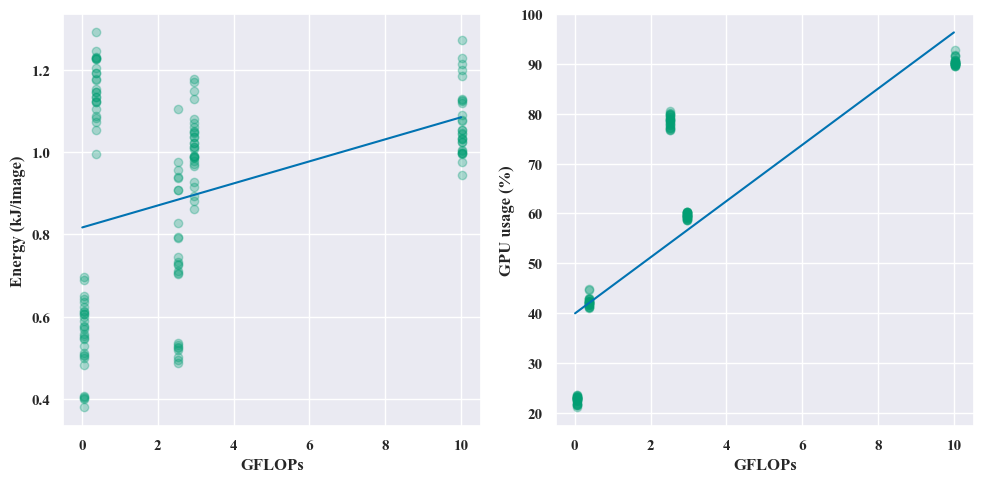

In [74]:
grouped_df = (
    analysis_df_no_outliers.query("`training environment` != 'Local N'")
    .groupby(["training environment", "architecture"], as_index=False)
    .agg(GFLOPs=("GFLOPs", "first"), energy=("energy", "median"), gpu_usage=("gpu_usage", "median"))
)

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

x = rq1_df.GFLOPs
y = rq1_df.energy

ax0.scatter(
    x,
    y,
    color=COLORS["Cloud"],
    alpha=0.3,
)

m, b = np.polyfit(x, y, 1)
samples = np.linspace(1e-2, 10, 100)
ax0.plot(samples, m * samples + b, color="b")

ax0.set_ylabel("Energy (kJ/image)")
ax0.set_xlabel("GFLOPs")

y = rq1_df.gpu_usage

ax1.scatter(
    x,
    y,
    color=COLORS["Cloud"],
    alpha=0.3,
)

ax1.set_ylabel("GPU usage (%)")
ax1.set_xlabel("GFLOPs")

# p1, p2 = np.polyfit(np.log(x), y, 1)
# ax1.plot(samples, p1 * np.log(samples) + p2, "r", label="logarithmic reg")

m, b = np.polyfit(x, y, 1)
ax1.plot(samples, m * samples + b, color="b", label="linear reg")
# ax1.legend()

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "cloud-energy-flops-regression.pdf"))

#### Correlation between FLOPs and Energy, and FLOPs and GPU usage

##### Local ML
Energy/FLOPs correlation

In [75]:
stats.spearmanr(local_ml_energy_vs_gpu_usage_df.energy, local_ml_energy_vs_gpu_usage_df.GFLOPs, alternative="greater")

SignificanceResult(statistic=0.8892674459623242, pvalue=4.027285702473069e-53)

GPU usage/FLOPs correlation

In [76]:
stats.spearmanr(
    local_ml_energy_vs_gpu_usage_df.gpu_usage, local_ml_energy_vs_gpu_usage_df.GFLOPs, alternative="greater"
)

SignificanceResult(statistic=0.9797741338970708, pvalue=5.129837057755373e-107)

##### Cloud
Energy/FLOPs correlation

In [77]:
stats.spearmanr(rq1_df.energy, rq1_df.GFLOPs, alternative="greater")

SignificanceResult(statistic=0.4302784461717513, pvalue=5.603353223257252e-08)

GPU usage/FLOPs correlation

In [78]:
stats.spearmanr(rq1_df.gpu_usage, rq1_df.GFLOPs, alternative="greater")

SignificanceResult(statistic=0.8873894360414593, pvalue=1.495000188124153e-48)

### RQ2 - Are local environments more energy-greedy than cloud environments when training DL models?

In [79]:
rq2_df = pd.concat([local_n_mobilenet, local_ml_mobilenet_no_gpu_outliers, cloud_mobilenet])

#### Energy
The energy data for RQ2 is not normally distributed. Therefore, the relevant results are obtained from the Kruskal-Wallis test.

Shapiro test for normality of group 0: W = 0.9629743099212646 and p-value 0.36816319823265076
Shapiro test for normality of group 1: W = 0.9178858995437622 and p-value 0.023647338151931763
Shapiro test for normality of group 2: W = 0.9638515114784241 and p-value 0.38700103759765625
Levene test for equal variances: W = 19.17920361946228 and p-value = 1.2572213273649175e-07


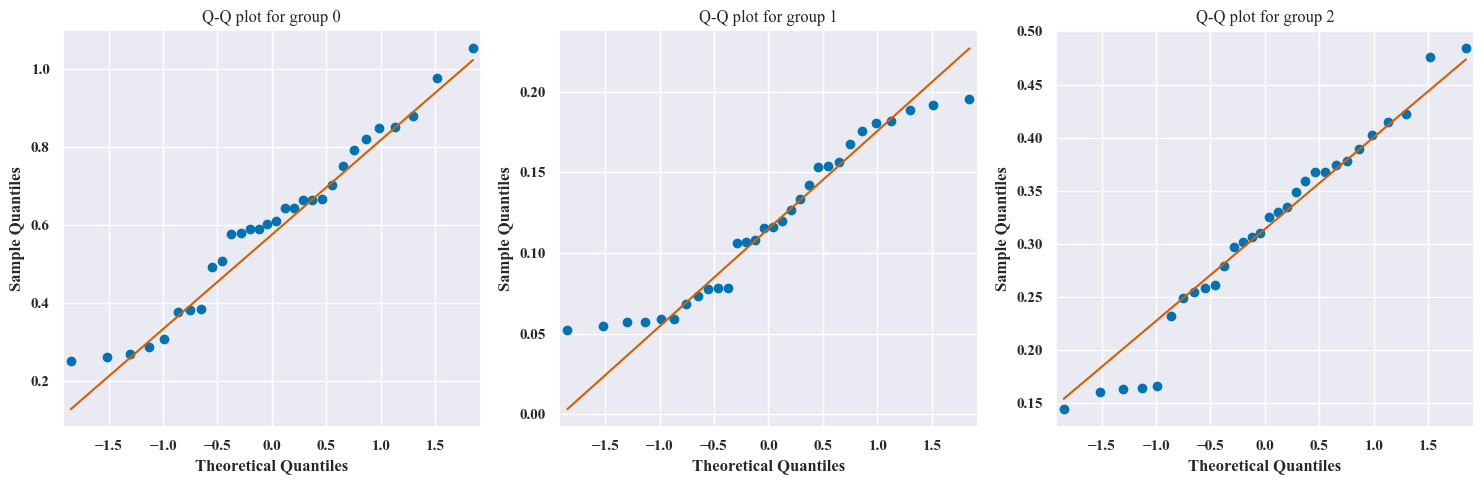

In [80]:
independent_variable = "training environment"
dependent_variable = "energy"

test_assumptions(
    rq2_df.query("`training environment` == 'Local N'")[dependent_variable],
    rq2_df.query("`training environment` == 'Local ML'")[dependent_variable],
    rq2_df.query("`training environment` == 'Cloud'")[dependent_variable],
    nrows=1,
    ncols=3,
    figsize=(15, 5),
)

##### Welch's ANOVA test

In [81]:
pg.welch_anova(rq2_df, dv=dependent_variable, between=independent_variable)

,Source,ddof1,ddof2,F,p-unc,np2
0,training environment,2,47.802453,108.920279,1.574759e-18,0.676684


##### Tukey post-hoc test

In [82]:
pg.pairwise_gameshowell(rq2_df, dv=dependent_variable, between=independent_variable)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Cloud,Local ML,0.310553,0.117857,0.192696,0.019066,10.106529,43.623197,1.602496e-12,2.575605
1,Cloud,Local N,0.310553,0.600590,-0.290038,0.043224,-6.710161,39.156367,1.565724e-07,-1.710055
2,Local ML,Local N,0.117857,0.600590,-0.482734,0.040738,-11.849705,31.831235,9.902079e-13,-3.019846


##### Kruskal-Wallis test

In [83]:
result_rq21 = pg.kruskal(rq2_df, dv=dependent_variable, between=independent_variable)
result_rq21

,Source,ddof1,H,p-unc
Kruskal,training environment,2,66.469744,3.683652e-15


##### Eta-squared measure

In [84]:
eta_squared(result_rq21["H"].item(), rq2_df[independent_variable].nunique(), rq2_df.shape[0])

0.7410315355142935

##### Dunn's test

In [85]:
p_values = sp.posthoc_dunn(rq2_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm")

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,Cloud,Local ML,Local N
Cloud,False,True,True
Local ML,True,False,True
Local N,True,True,False


In [86]:
local = rq2_df[dependent_variable][rq2_df["training environment"] == "Local N"]
local_ml = rq2_df[dependent_variable][rq2_df["training environment"] == "Local ML"]
Cloud = rq2_df[dependent_variable][rq2_df["training environment"] == "Cloud"]

print(f"Local - Local ML effect size: {cliffs_delta(local, local_ml)}")
print(f"Local - Cloud effect size: {cliffs_delta(local, Cloud)}")
print(f"Local ML - Cloud effect size: {cliffs_delta(local_ml, Cloud)}")

Local - Local ML effect size: (1.0, 'large')
Local - Cloud effect size: (0.7377777777777778, 'large')
Local ML - Cloud effect size: (-0.9155555555555556, 'large')


#### GPU usage
As with the energy data, GPU usage data is not normally distributed. Therefore, the relevant results are obtained from the Kruskal-Wallis test.


In [87]:
local = rq2_df.gpu_usage[rq2_df["training environment"] == "Local N"]
local_ml = rq2_df.gpu_usage[rq2_df["training environment"] == "Local ML"]
Cloud = rq2_df.gpu_usage[rq2_df["training environment"] == "Cloud"]

dependent_variable = "gpu_usage"

Shapiro test for normality of group 0: W = 0.9337794780731201 and p-value 0.06192095950245857
Shapiro test for normality of group 1: W = 0.955195963382721 and p-value 0.23238784074783325
Shapiro test for normality of group 2: W = 0.9209879040718079 and p-value 0.028453435748815536
Levene test for equal variances: W = 15.169472968055345 and p-value = 2.23024485312008e-06


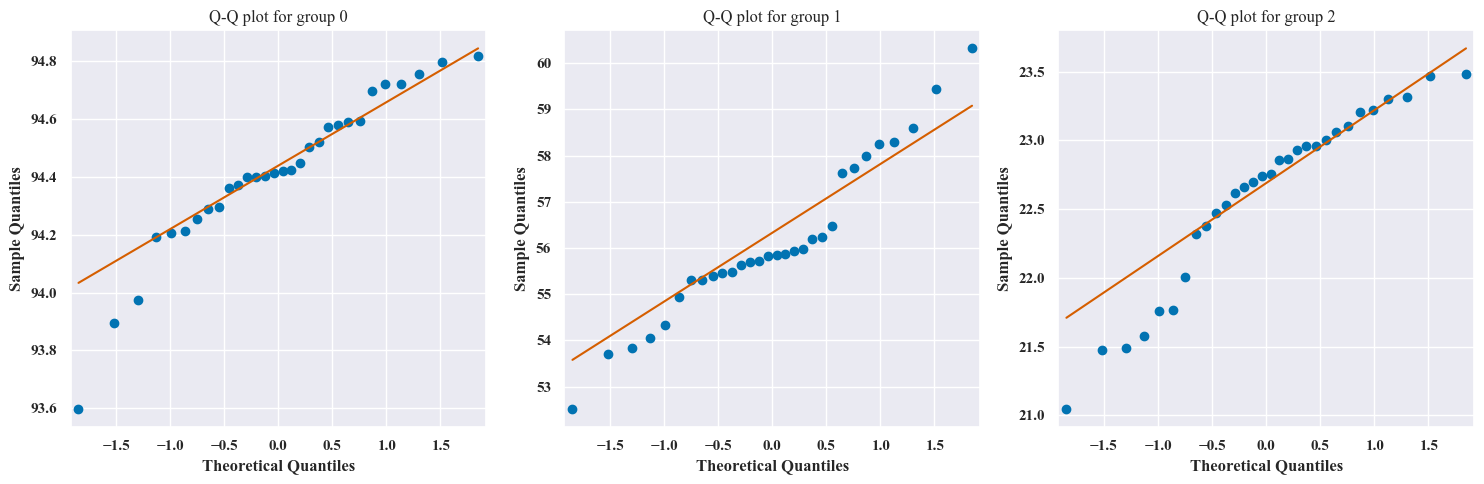

In [88]:
test_assumptions(local, local_ml, Cloud, nrows=1, ncols=3, figsize=(15, 5))

##### Welch's ANOVA test

In [89]:
pg.welch_anova(rq2_df, dv=dependent_variable, between=independent_variable)

,Source,ddof1,ddof2,F,p-unc,np2
0,training environment,2,45.022708,155853.634848,3.530936e-87,0.998665


##### Games-Howell post-hoc test

In [90]:
pg.pairwise_gameshowell(rq2_df, dv=dependent_variable, between=independent_variable)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Cloud,Local ML,22.601064,56.133512,-33.532447,0.341405,-98.218899,36.900852,6.439294e-15,-25.030660
1,Cloud,Local N,22.601064,94.414385,-71.813321,0.129185,-555.896548,38.815542,3.552714e-15,-141.667821
2,Local ML,Local N,56.133512,94.414385,-38.280874,0.323767,-118.235941,30.403486,9.992007e-16,-30.131916


##### Kruskal-Wallis test

In [91]:
result_rq22 = pg.kruskal(rq2_df, dv=dependent_variable, between=independent_variable)
result_rq22

,Source,ddof1,H,p-unc
Kruskal,training environment,2,79.120879,6.593551e-18


##### Eta-squared measure

In [92]:
eta_squared(result_rq22["H"].item(), rq2_df[independent_variable].nunique(), rq2_df.shape[0])

0.8864468864468865

##### Dunn's test

In [93]:
p_values = sp.posthoc_dunn(rq2_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm")

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,Cloud,Local ML,Local N
Cloud,False,True,True
Local ML,True,False,True
Local N,True,True,False


In [94]:
print(f"Local - Local ML effect size: {cliffs_delta(local, local_ml)}")
print(f"Local - Cloud effect size: {cliffs_delta(local, Cloud)}")
print(f"Local ML - Cloud effect size: {cliffs_delta(local_ml, Cloud)}")

Local - Local ML effect size: (1.0, 'large')
Local - Cloud effect size: (1.0, 'large')
Local ML - Cloud effect size: (1.0, 'large')
